# **Use case ML: price prediction of used bikes**

In [121]:
########### Loading in Libs ###########

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve, KFold
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import pickle
import joblib
import shutil
import os
import gzip

########### Style for Plots  ###########

plt.style.use('ggplot')

np.int = np.int_ #fix needed for the py version i used

**Table of contents**<a id='toc0_'></a>    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Data Analysis:

In [83]:
df_all_brands = pd.read_pickle("df_all_brands.pkl")

In [84]:
########### Sind irgendwelche Special Editions / Haben Sammlerwert ###########

Z = df_all_brands[df_all_brands['price'] < 50000] 

########### Kategorien ausschließen und richtig zuordnen ###########

Z = Z[~Z['Category'].isin( ["Prototype / concept model", "Scooter", "Unspecified category","Super motard"])]
Z.loc[Z["Category"] == "Cross / motocross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Minibike, cross", "Category"] = "Enduro / offroad"
Z.loc[Z["Category"] == "Sport touring", "Category"] = "Touring"

########### Sortieren für das Splitting später ###########

Z = Z.sort_values(by = 'price')
Z = Z.reset_index(drop=True)
Z['price'] = Z['price']*0.92 #in Euro
Z['mileage'] = Z['mileage']*1.60934 #in km

Z = Z.rename(columns = {"mileage":"Mileage [km]", "Displacement (ccm)": "Displacement [ccm]", "Torque (Nm)": "Torque [Nm]", "Power (hp)":"Power [hp]", "Age": "Age [a]"})

########### dealing with categorical features ###########

Z_num = pd.get_dummies(Z, columns=['Brand', 'Condition'], drop_first=True) 

########### Manual Frequency Mapping ###########

freq_Bike = Z_num["Bike"].value_counts().to_dict()
Z_num["Bike"] = Z_num["Bike"].map(freq_Bike)
freq_Cat = Z_num["Category"].value_counts().to_dict()
Z_num["Category"] = Z_num["Category"].map(freq_Cat)

########### Splitting into Attributes and Target ###########

X = Z.drop('price', axis=1) 
y = Z['price']


X_num = Z_num.drop('price', axis=1) 
y_num = Z_num['price']


########### Splitting into different Price Ranges (not used later) ###########

n = int(Z.shape[0] / 5)
Split_Z = [Z[i:i+n].copy() for i in range(0,Z.shape[0],n)]

Z1, Z2, Z3, Z4, Z5 = Split_Z[0], Split_Z[1], Split_Z[2], Split_Z[3], Split_Z[4]
X1, X2, X3, X4, X5 = Z1.drop('price', axis=1), Z2.drop('price', axis=1) , Z3.drop('price', axis=1) , Z4.drop('price', axis=1) , Z5.drop('price', axis=1)
y1, y2, y3, y4, y5 = Z1['price'], Z2['price'], Z3['price'], Z4['price'], Z5['price']

########### Log scaling for cases where i needed the whole dataset ###########

y_log_num = np.log1p(y_num)
y_log = np.log1p(y)
Z


Mileage [km]     price            Bike   Brand         Category  \
0       1931.20800   1283.40     vinoclassic  yamaha          scooter   
1          1.60934   1425.08         tt-r50e  yamaha  minibike, cross   
2          1.60934   1563.08            pw50  yamaha  minibike, cross   
3          3.21868   1563.08            pw50  yamaha  minibike, cross   
4       2414.01000   1564.00           xs650  yamaha          classic   
...            ...       ...             ...     ...              ...   
3427    2655.41100  44150.80     panigalev4r  ducati            sport   
3428     300.94658  44619.08  superleggerav4  ducati       naked bike   
3429     482.80200  45908.00     panigalev4s  ducati            sport   
3430    1689.80700  45995.40  superleggerav4  ducati       naked bike   
3431    9417.85768  45999.08           900ss  ducati            sport   

      Displacement [ccm]  Power [hp]  Torque [Nm]  Condition  Age [a]  
0                  124.0  103.949842    81.543772       True       17  
1                   49.0  103.949842    81.543772      False        1  
2                   49.0    2.700000     3.800000      False        0  
3                   49.0    2.700000     3.800000      False        0  
4                  654.0   50.000000    81.543772       True       41  
...                  ...         ...          ...        ...      ...  
3427               998.0  217.000000   112.000000       True        4  
3428               998.0  221.000000   116.000000       True        9  
3429              1103.0  214.000000   124.000000       True        0  
3430               998.0  221.000000   116.000000       True        9  
3431               864.0   70.000000   108.807294       True       46  

[3432 rows x 10 columns]

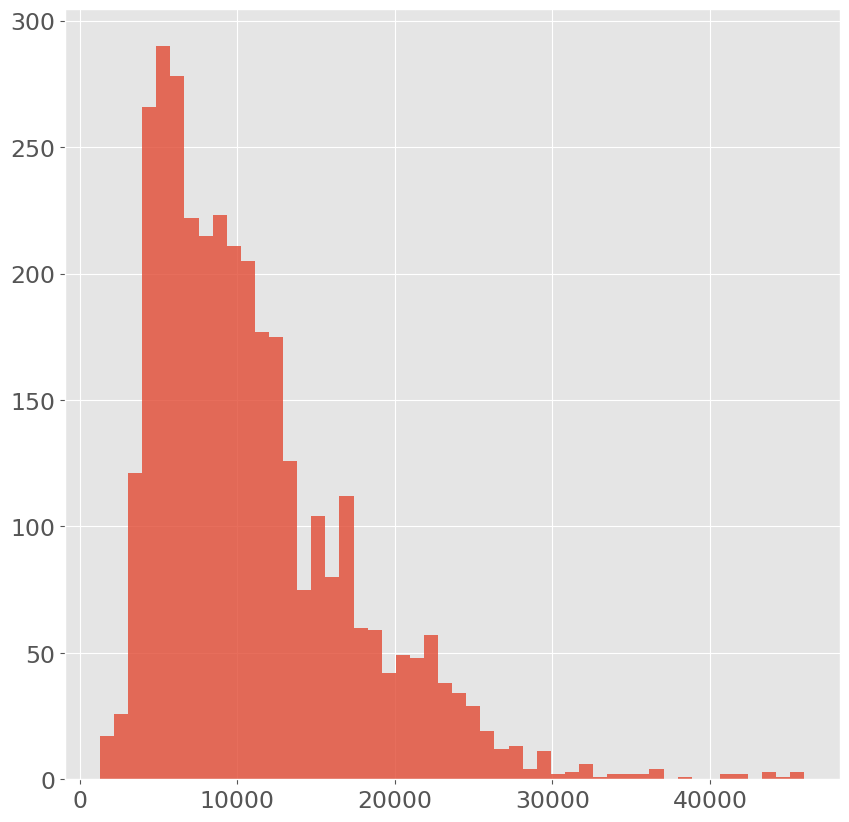

In [85]:
########### Price distribution ###########

y.hist(alpha=0.8, figsize=(10, 10), bins = 50)
plt.show()

/var/folders/zd/qsfm1f5d39ddz1bnq9k3xjwr0000gn/T/ipykernel_40701/3731650136.py:15: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)


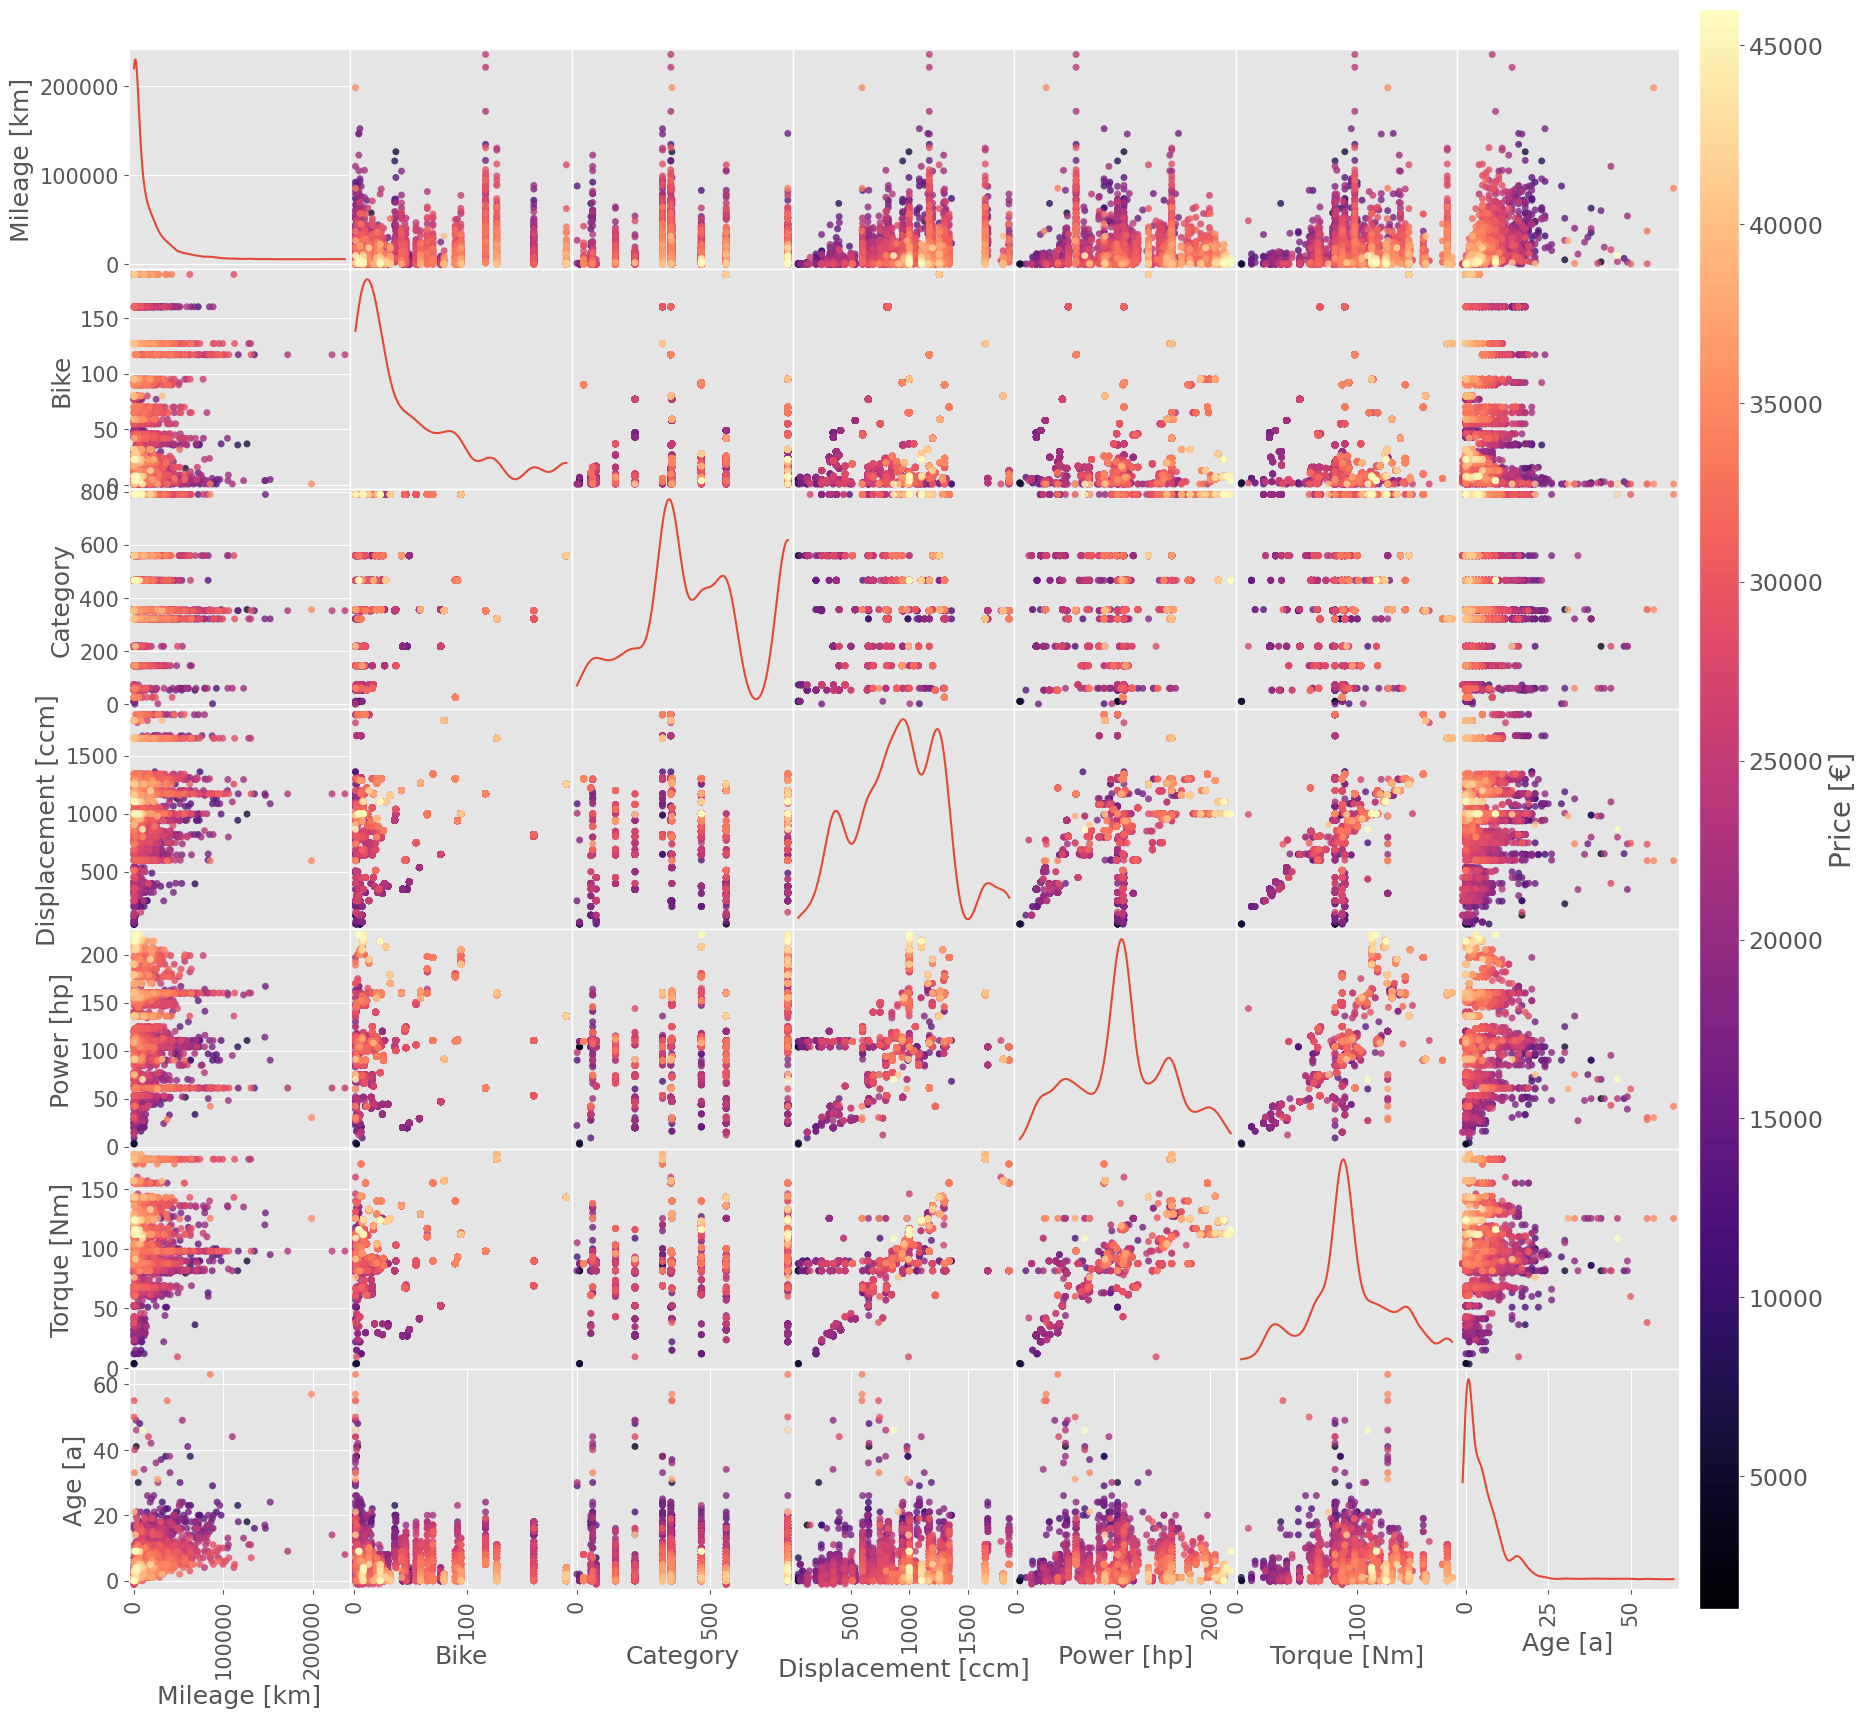

In [86]:
########### Scatter matrix ###########

from pandas.plotting import scatter_matrix
import matplotlib.colors as mcolors

y_mm_num = minmax_scale(y_num, feature_range=(0, 1))
y_log_num = np.log1p(y_num)

plt.rcParams['axes.labelsize'] = 18
fig, ax = plt.subplots(figsize=(20, 20))

cmap = plt.get_cmap('magma')
norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

scatter_matrix_plot  = scatter_matrix(X_num.iloc[:, :7],c=y_log_num, alpha=0.8, s=100,  cmap='magma', grid = True, diagonal = 'kde',hist_kwds = {'bins':50}, ax=ax)
plt.subplots_adjust(right=0.9)

for ax1 in scatter_matrix_plot.ravel():
    ax1.tick_params(axis='both', which='major', labelsize=15)

cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, cax=cbar_ax)
cb.set_label('Price [€]', fontsize = 20)

plt.show()

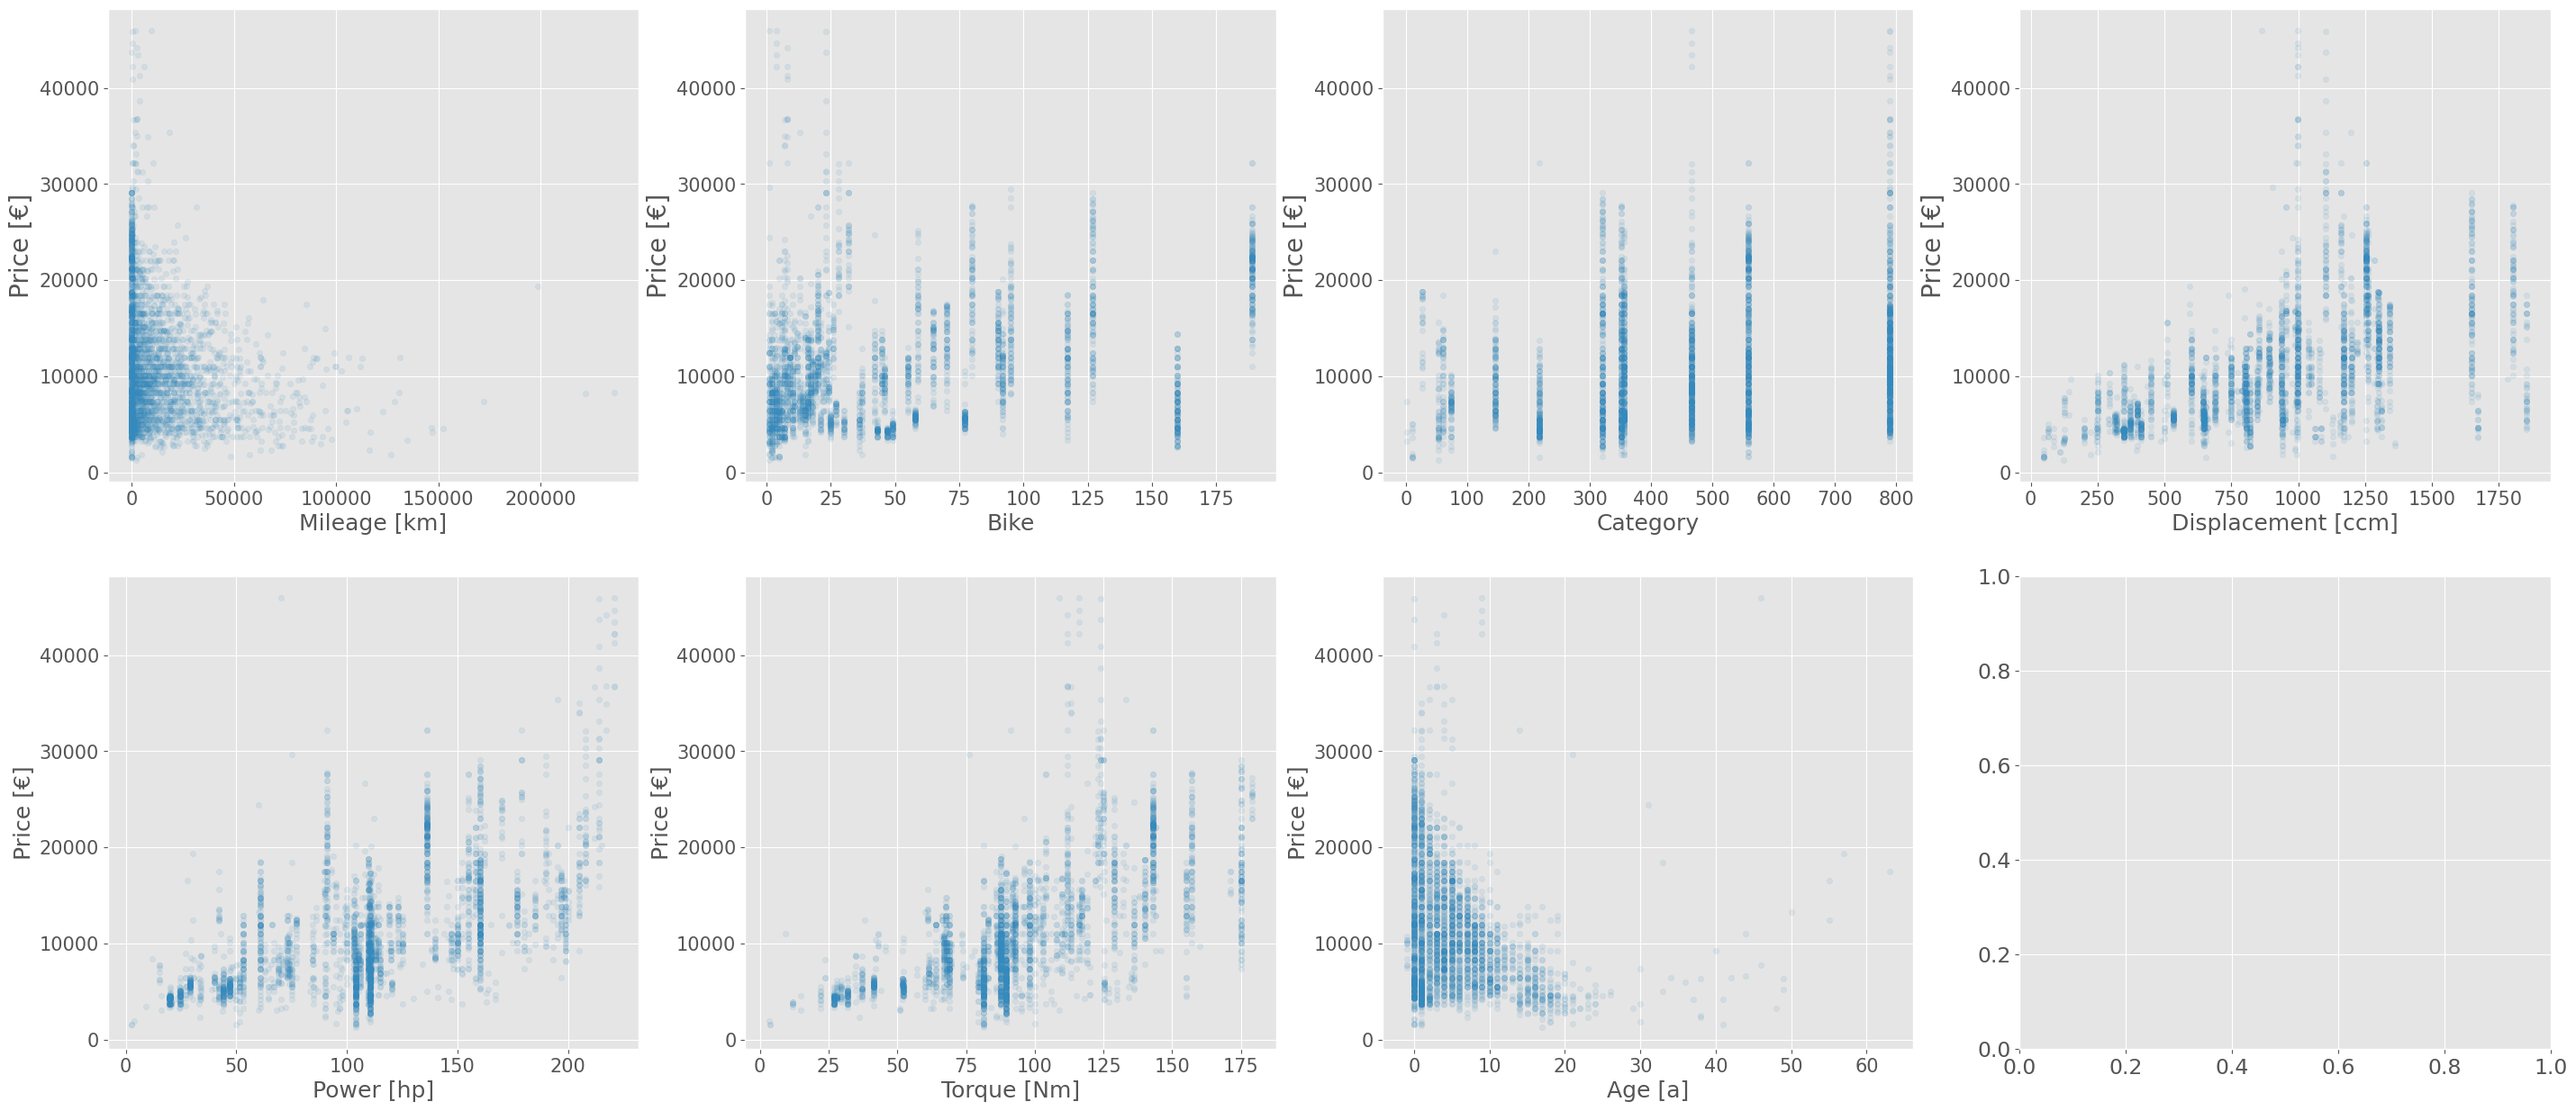

In [87]:
########### scatter plots ###########

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(35,15))


for xcol, ax in zip(['Mileage [km]', 'Bike', 'Category', 'Displacement [ccm]'], axes[0,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1,ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylabel('Price [€]', fontsize=20)

for xcol, ax in zip(['Power [hp]', 'Torque [Nm]', 'Age [a]'], axes[1,:]):
    Z_num.plot(kind='scatter', x=xcol, y='price',ax=ax, alpha=0.1, ylabel='Price [€]')
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

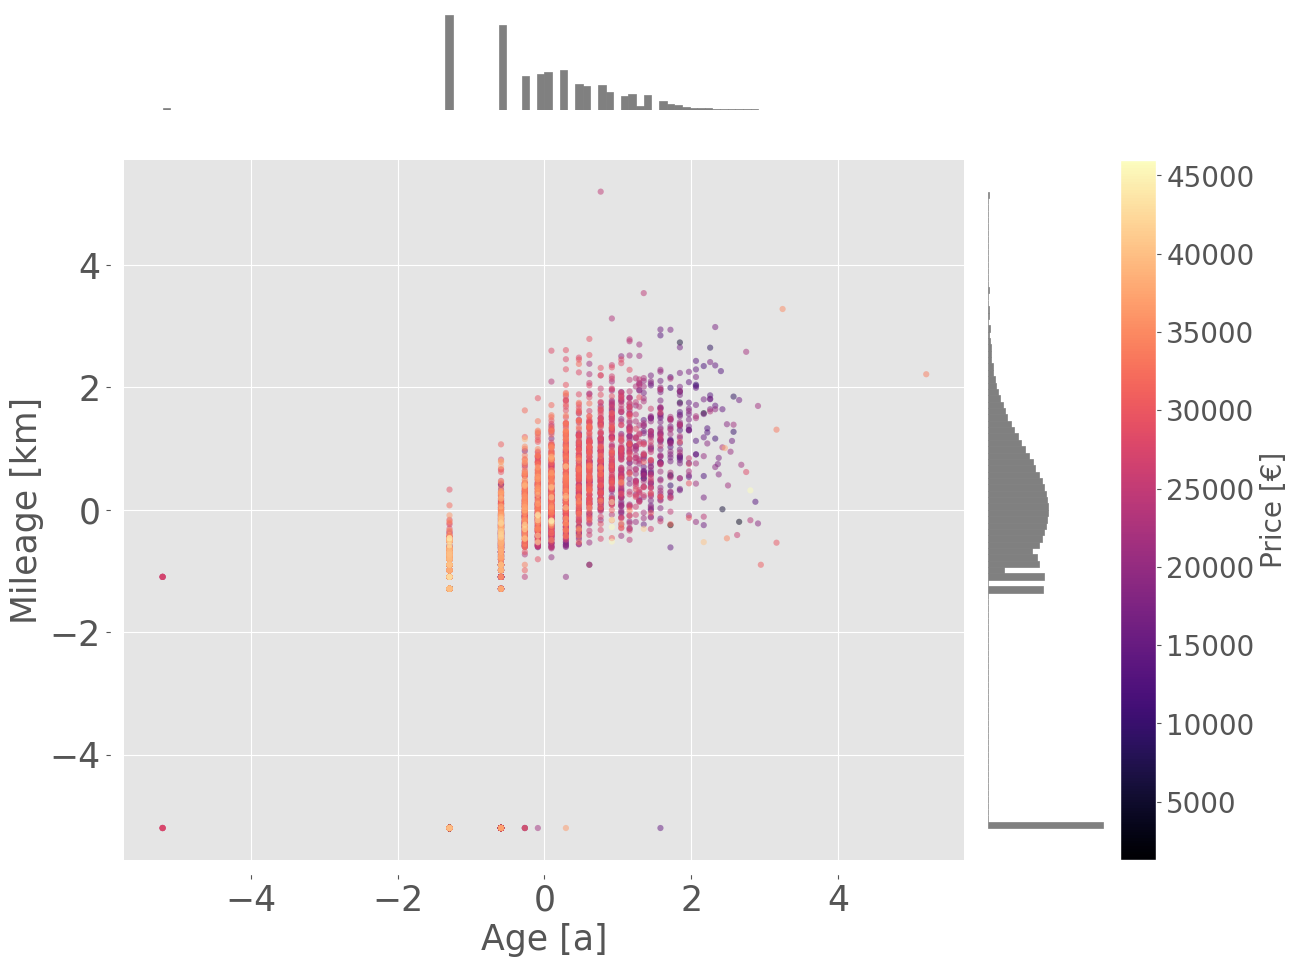

In [88]:
########### Different scalings ###########

X_Standard = StandardScaler().fit_transform(X_num)
X_Standard = MinMaxScaler().fit_transform(X_num)
X_MaxAbs = MaxAbsScaler().fit_transform(X_num)
X_Robust = RobustScaler(quantile_range=(25, 75)).fit_transform(X_num)
X_Uni = QuantileTransformer(output_distribution='uniform').fit_transform(X_num)
X_Normal = QuantileTransformer(output_distribution='normal').fit_transform(X_num)
X_L2 = Normalizer().fit_transform(X_num)

fig = plt.figure(figsize=(12,10))

X_ = X_Normal                        ########### CHANGE THIS FOR DIFFERENT SCALINGS -> X_Standard, X_MaxAbs, X_Robust, X_Uni, X_Normal, X_L2 ###########
left, width = 0.1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.1]
rect_histy = [left_h, bottom, 0.1, height]

ax_scatter = plt.axes(rect_scatter)
ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)

left, width = width + left + 0.13, 0.03

rect_colorbar = [left, bottom, width, height]
ax_colorbar = plt.axes(rect_colorbar)

ax, hist_X1, hist_X0 = ax_scatter, ax_histy, ax_histx

x0_label="Age [a]"
x1_label="Mileage [km]"

ax.set_xlabel(x0_label, fontsize=25)
ax.set_ylabel(x1_label, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax_colorbar.tick_params(axis='both', which='major', labelsize=20)
ax_colorbar.set_ylabel('Price [€]', fontsize=20)

cmap = plt.get_cmap('magma')

ax.scatter(X_[:,6], X_[:,0], alpha=0.5,c=y_log_num,cmap = cmap, marker='o', s=20, lw=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

hist_X1.set_ylim(ax.get_ylim())
hist_X1.hist(X_[:,0], bins=100, orientation='horizontal',
                color='grey', ec='grey')
hist_X1.axis('off')                 

hist_X0.set_xlim(ax.get_xlim())
hist_X0.hist(X_[:,6], bins=100, orientation='vertical',
                color='grey', ec='grey')

hist_X0.axis('off')

norm = mcolors.Normalize(vmin=y_num.min(), vmax=y_num.max())

cb = matplotlib.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              orientation='vertical',
                              label='Price [€]', norm = norm)

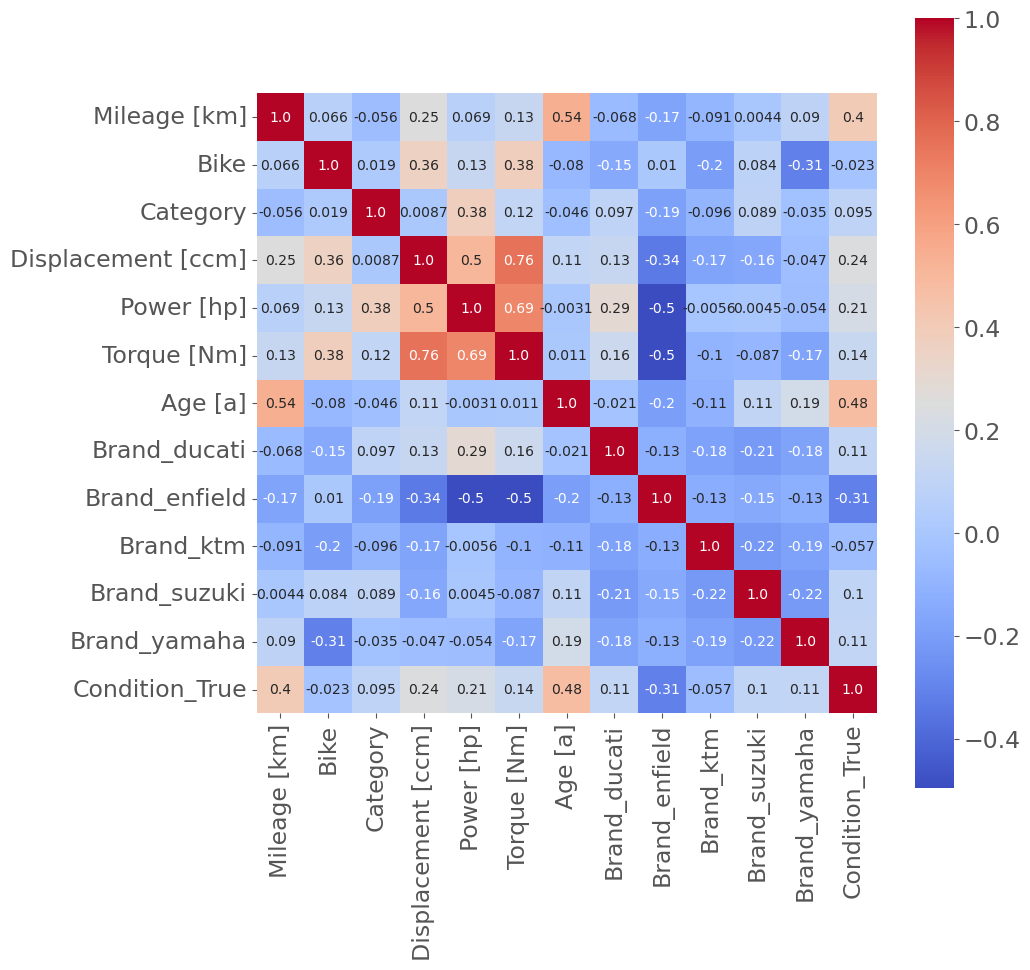

In [89]:
########### Correlation matrix ###########

Z_temp = X_num[:]
plt.figure(figsize=(10,10))
sns.heatmap(data = Z_temp.iloc[:].corr(), annot=True, square=True, cmap='coolwarm', label='Correlation', fmt=".2")
plt.show()

## **Machine Learning:**

### Scalers, Transformers and Pipelines:

In [90]:
########### Numerical and Categorical Features ###########

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_ = X.select_dtypes(include=['object', 'string[python]', 'bool']).columns.tolist()

########### Preprocessing for numerical data ###########

num_transformer_std = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

num_transformer_norm = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', QuantileTransformer(output_distribution='normal'))
])

num_transformer_robust = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler(quantile_range=(25, 75)))
])

num_transformer_none = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

########### Preprocessing for categorical data ###########

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#For CatBoost
cat_transformer_cat = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))]) 

########### Define different preprocessors for numerical data ##########

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_norm = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_robust = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer, cat_features_)
    ])
preprocessor_none = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer, cat_features_)
    ])

#For CatBoost

preprocessor_none_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_none, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_std_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_std, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_norm_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_norm, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

preprocessor_robust_cat = ColumnTransformer(
    transformers=[
        ('num', num_transformer_robust, num_features),
        ('cat', cat_transformer_cat, cat_features_)
    ])

########### Transformer for the Price ###########

target_transformer_log = FunctionTransformer(np.log1p,inverse_func=np.expm1, validate=True)
target_transformer_mm = MinMaxScaler()

### Train - Test Split:

In [91]:
########### Train - Test - Splitting ###########

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

########### Log Transformation ###########

y_train_log = target_transformer_log.fit_transform(y_train.values.reshape(-1, 1))
y_test_log = target_transformer_log.transform(y_test.values.reshape(-1, 1))

y_train_mm = target_transformer_mm.fit_transform(y_train.values.reshape(-1, 1)).reshape(-1)
y_test_mm = target_transformer_mm.transform(y_test.values.reshape(-1, 1)).reshape(-1)

########### Define Scorers for the Cross validation ###########

def rmsle_score(y_true, y_pred):
    #y_true = target_transformer_mm.inverse_transform(y_true.reshape(-1, 1)).reshape(-1)  ########### SWITCH IF MIN MAX SCALING IS USED INSTEAD OF LOG ###########
    #y_pred = target_transformer_mm.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))
def mse_score(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return mean_squared_error(y_true, y_pred)
def mae_score(y_true, y_pred):
    y_true = np.expm1(y_true)  
    y_pred = np.expm1(y_pred)
    return mean_absolute_error(y_true, y_pred)
def r2_score1(y_true, y_pred):
    y_true = np.expm1(y_true) 
    y_pred = np.expm1(y_pred)
    return r2_score(y_true, y_pred)

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)
r2_scorer = make_scorer(r2_score1, greater_is_better=False)
mse_scorer = make_scorer(mse_score, greater_is_better=False)
mae_scorer = make_scorer(mae_score, greater_is_better=False)

########### KFold for Cross Validation ###########

kf = KFold(n_splits=10, shuffle=True, random_state=123)

### **Training Models:**

#### **XGBOOST TREE**

In [92]:
########### Define Parameter Grid ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


########### Initialize Base Model ###########

xgb_tree_model = XGBRegressor(objective='reg:squarederror', booster='gbtree', random_state=42, enable_categorical=True)

########### Use Pipeline on Base Model ###########

model_xgbtree = Pipeline(steps=[
    ('preprocessor', preprocessor_norm),  ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_tree_model)
])

########### Random Search for best parameters ###########

#random_search_xgbtree = RandomizedSearchCV(estimator=model_xgbtree, param_distributions=param_grid_xgbtree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgbtree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgbtree_std_log = {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_norm_log = {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_robust_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_none_log = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
best_params_xgbtree_std_mm = {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgbtree = best_params_xgbtree_norm_log
#random_search_xgbtree.best_params_ ########### Parameters of Grid Search

########### Set Parameters ###########

best_xgbtree = model_xgbtree.set_params(**best_params_xgbtree)
start = time.time() ########### Track Time
best_xgbtree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgbtree = best_xgbtree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgbtree_inv = target_transformer_log.inverse_transform(y_pred_xgbtree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########
 
cv_scores_xgbtree_rmsle = cross_val_score(best_xgbtree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Tree: ")
print(f"Best parameters: {best_params_xgbtree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Tree: 
Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}
Cross-Validation RMSE Scores: [1892.0430188  2084.67338509 2988.04307101 2318.8876433  1955.35662969
 1781.86824253 1884.16850139 2331.57504568 2570.81712139 2202.81192894]
Mean RMSE: 2201.0244587818506
Standard Deviation of RMSE: 351.074451730886
MSE: 6914877.38
MAE: 1457.37
R2-Score: 0.869
Training time: 1.552677869796753s


##### **XGBoost Metrics:**

**Metrics for XGBoost Tree Log Standard:**

Best parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2112.02973138 3359.98328441 2116.63709523 2258.95546336 2534.21538524 2075.57920921 2803.52390877 2532.2391268  2469.95961849 1741.7229471 ]

Mean RMSE: 2400.48

Standard Deviation of RMSE: 429.71

MSE: 4557951.89

MAE: **1350.62**

R2-Score: **0.894**

Training time: 2.37s


**Metrics for XGBoost Tree Log Normalised: (BEST)**

Best parameters: {'regressor__subsample': 0.4, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 4, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.08, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2161.23741596 3322.02786192 2137.90912851 2315.7989309  2587.76970711 2112.66001255 2676.10762662 2330.87051486 2369.97988735 1778.2157678 ]

Mean RMSE: 2379.26

Standard Deviation of RMSE: 395.60

MSE: 4514569.40

MAE: **1352.13**

R2-Score: **0.897**

Training time: 2.42s


**Metrics for XGBoost Tree Robust:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2085.10909863 3393.07532792 2223.32343396 2414.82424385 2626.12583229 2026.79056983 2698.34018201 2447.40098379 2373.95324535 1760.78647443]

Mean RMSE: 2404.97

Standard Deviation of RMSE: 425.15

MSE: 4500529.41

MAE: **1356.10**

R2-Score: **0.895**

Training time: 2.71


**Metrics for XGBoost Tree Log No Scaling:**

Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 5, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2075.83261461 3322.12092512 2164.67377904 2332.07881493 2616.94182646 2014.93333682 2721.03162476 2500.56481784 2381.85544236 1762.41658875]

Mean RMSE: 2389.245

Standard Deviation of RMSE: 415.883

MSE: 4479635.33

MAE: **1342.35**

R2-Score: **0.897**

Training time: 2.351s


**Metrics for XGBoost Tree MM Standard:**

Best parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.01, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 300, 'regressor__min_child_weight': 1, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0, 'regressor__colsample_bytree': 0.6}

Cross-Validation RMSE Scores: [2288.1187393  3436.89222874 2219.56272654 1924.27277691 2685.30148106 2146.61733512 2622.66234688 2507.47615984 2729.01564972 2307.90476099]

Mean RMSE: 2486.78

Standard Deviation of RMSE: 399.34

MSE: 4706014.85

MAE: **1447.28**

R2-Score: **0.878**

Training time: 5.20

In [93]:
print(best_xgbtree.named_steps['regressor'])

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


#### **XGBOOST LIN**

In [94]:
########### Define Parameter Grid ###########

param_grid_xgblin = {
    'regressor__learning_rate': [0.06, 0.08, 0.1, 0.12],
    'regressor__alpha': [1.3, 1.5, 1.7],
    'regressor__lambda': [0.001, 0.1, 1],
    'regressor__n_estimators': [300, 320, 349],
    'regressor__reg_alpha': [0, 0.001, 0.01],
    'regressor__reg_lambda': [0.003, 0.005, 0.01]
}

########### Initialize Base Model ###########

xgb_lin_model = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', random_state=50)

########### Use Pipeline on Base Model ###########

model_xgblin = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', xgb_lin_model)
])

########### Random Search for best parameters ###########

#random_search_xgblin = RandomizedSearchCV(estimator=model_xgblin, param_distributions=param_grid_xgblin, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_xgblin.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_xgblin_std_log = {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}
best_params_xgblin_norm_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_robust_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}
best_params_xgblin_none_log = {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
#random_search_xgblin.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_xgblin = best_params_xgblin_none_log

########### Set Parameters ###########

best_xgblin = model_xgblin.set_params(**best_params_xgblin)
start = time.time()
best_xgblin.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_xgblin = best_xgblin.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_xgblin_inv = target_transformer_log.inverse_transform(y_pred_xgblin.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_xgblin_rmsle = cross_val_score(best_xgblin, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for XGBoost Lin: ")
print(f"Best parameters: {best_params_xgblin}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgblin_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgblin_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgblin_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgblin_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgblin_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgblin))
print(f"Training time: {stop - start}s")

Metrics for XGBoost Lin: 
Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}
Cross-Validation RMSE Scores: [2262.57052966 3592.27647352 3590.07753572 3539.01731492 2549.62950094
 2984.14864222 2765.60911548 4131.84947134 3155.97919091 3035.42753849]
Mean RMSE: 3160.6585313210785
Standard Deviation of RMSE: 532.9075862523356
MSE: 11730935.23
MAE: 2108.94
R2-Score: 0.717
Training time: 1.4078099727630615s


##### **XGBOOST LIN METRICS:**

**Metrics for XGBoost Lin Standard:**

Best parameters: {'regressor__reg_lambda': 0.005, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.001, 'regressor__alpha': 1.5}

Cross-Validation RMSE Scores: [2875.92350078 3813.3397601  3527.17262871 3599.8244191  3509.00374465 2826.62478785 3840.11190907 3346.20591247 4341.02300559 2708.38487218]

Mean RMSE: 3438.76

Standard Deviation of RMSE: 488.64

MSE: 8740382.35

MAE: **1920.28**

R2-Score: **0.783**

Training time: 2.37s


**Metrics for XGBoost Lin Normalised:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

Cross-Validation RMSE Scores: [2978.67539117 3831.7430115  3583.40216116 3240.15981843 3411.10240912 2844.63171407 3608.77164637 3248.2082167  3841.29823349 2905.98954913]

Mean RMSE: 3349.40

Standard Deviation of RMSE: 348.06

MSE: 9572071.25

MAE: **2082.50**

R2-Score: **0.765**

Training time: 2.45s

**Metrics for XGBoost Lin Robust: (BEST)**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 320, 'regressor__learning_rate': 0.12, 'regressor__lambda': 0.1, 'regressor__alpha': 1.3}

ross-Validation RMSE Scores: [3135.96235869 3812.42318278 3587.86662636 3384.04775868 3606.06094928 2650.43955494 3930.40119147 3443.79756281 4347.24998711 2709.42401445]

Mean RMSE: 3460.77

Standard Deviation of RMSE: 500.02

MSE: 8402075.27

MAE: **1915.19**

R2-Score: **0.787**

Training time: 3.43

**Metrics for XGBoost Lin No Scaling:**

Best parameters: {'regressor__reg_lambda': 0.003, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 349, 'regressor__learning_rate': 0.08, 'regressor__lambda': 0.1, 'regressor__alpha': 1.7}

Cross-Validation RMSE Scores: [2838.05481834 3924.09805536 3583.14428551 3579.86077855 3657.67248474 2675.76984055 3788.55376952 3417.78301586 4226.34412204 2749.16816792]
 
Mean RMSE: 3444.05

Standard Deviation of RMSE: 498.56

MSE: 9371909.08

MAE: **2027.86**

R2-Score: **0.764**

Training time: 2.54s


#### **CatBoost:**

In [95]:
########### Define Parameter Grid ###########

param_grid_catboost = {
    'regressor__iterations': [500, 1000],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__depth': [4, 6, 8, 10],
    'regressor__l2_leaf_reg': [1, 3, 5, 7],
    'regressor__bagging_temperature': [0.5, 1],
    'regressor__random_strength': [0.05, 1, 5],
    'regressor__border_count': [32, 64, 128],
    'regressor__min_data_in_leaf': [1, 3, 10],
    'regressor__one_hot_max_size': [2, 10, 20]
}

########### Index of Cat features after preprocessor ###########

cat_features__ = [5, 6, 7, 8]

########### Initialize Base Model ###########

catboost_model = CatBoostRegressor(random_seed=42, cat_features= cat_features__)

########### Use Pipeline on Base Model ###########

model_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor_std_cat), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('regressor', catboost_model)
])

########### Random Search for best parameters ###########

#random_search_catboost = RandomizedSearchCV(estimator=model_catboost.set_params(regressor__cat_features= cat_features__), param_distributions=param_grid_catboost, cv=kf, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

########### Fitting for Randomized Search ###########

#random_search_catboost.fit(X_train, y_train_log, regressor__cat_features= cat_features__)

########### Best Parameters from Search ###########

best_params_catboost_std_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
best_params_catboost_norm_log = {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}
best_params_catboost_robust_log = {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}
best_params_catboost_none_log =  {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
#random_search_catboost.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_catboost = best_params_catboost_std_log

########### Set Parameters ###########

best_catboost = model_catboost.set_params(**best_params_catboost,)

start = time.time()
best_catboost.fit(X_train, y_train_log, regressor__cat_features =cat_features__) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_catboost = best_catboost.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_catboost_inv = target_transformer_log.inverse_transform(y_pred_catboost.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_catboost_rmsle = cross_val_score(best_catboost, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for CatBoost: ")
print(f"Best parameters: {best_params_catboost}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_catboost_rmsle}")
print(f"Mean RMSE: {-cv_scores_catboost_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_catboost_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_catboost_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_catboost_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_catboost))
print(f"Training time: {stop - start}s")

0:	learn: 0.5203376	total: 19ms	remaining: 9.49s
1:	learn: 0.4868532	total: 25.2ms	remaining: 6.26s
2:	learn: 0.4585872	total: 30.9ms	remaining: 5.11s
3:	learn: 0.4334838	total: 33.2ms	remaining: 4.12s
4:	learn: 0.4104279	total: 37.4ms	remaining: 3.71s
5:	learn: 0.3890230	total: 40ms	remaining: 3.29s
6:	learn: 0.3714713	total: 42.1ms	remaining: 2.96s
7:	learn: 0.3549587	total: 47.2ms	remaining: 2.9s
8:	learn: 0.3392195	total: 49.2ms	remaining: 2.68s
9:	learn: 0.3248954	total: 50.5ms	remaining: 2.47s
10:	learn: 0.3133482	total: 54ms	remaining: 2.4s
11:	learn: 0.3023295	total: 56.1ms	remaining: 2.28s
12:	learn: 0.2921142	total: 58ms	remaining: 2.17s
13:	learn: 0.2838602	total: 60.3ms	remaining: 2.09s
14:	learn: 0.2758625	total: 63.1ms	remaining: 2.04s
15:	learn: 0.2687615	total: 64.8ms	remaining: 1.96s
16:	learn: 0.2616599	total: 66.7ms	remaining: 1.89s
17:	learn: 0.2561220	total: 69.2ms	remaining: 1.85s
18:	learn: 0.2497449	total: 70.9ms	remaining: 1.79s
19:	learn: 0.2442017	total: 72.5

##### METRICS CATBOOST:

**Metrics for Catboost Log Standard (BEST):**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 10, 'regressor__min_data_in_leaf': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 7, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2054.22396583 3185.68220274 2242.48420856 2270.15758479 2503.43829942 2013.0169515  2588.78605261 2517.41866886 2302.57048513 1663.35454145]

Mean RMSE: 2334.11

Standard Deviation of RMSE: 386.93

MSE: 4146873.05

MAE: **1297.27**

R2-Score: **0.902**

Training time: 2.15

**Metrics for Catboost Normalised:** 

Best parameters: {'regressor__random_strength': 0.05, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 6, 'regressor__border_count': 128, 'regressor__bagging_temperature': 0.5}

Cross-Validation RMSE Scores: [2159.76198192 3140.28206616 2155.62470872 2092.91998605 2474.50740455 1957.51152263 2496.91183554 2524.20096755 2319.4981183  1662.72679045]

Mean RMSE: 2298.39

Standard Deviation of RMSE: 378.51

MSE: 4407888.22

MAE: **1320.62**

R2-Score: **0.899**

Training time: 1.73s

**Metrics for Catboost Robust:**

Best parameters: {'regressor__random_strength': 1, 'regressor__one_hot_max_size': 2, 'regressor__min_data_in_leaf': 3, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 3, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}

Cross-Validation RMSE Scores: [2206.89994378 3158.02482086 2264.00659475 2098.50868624 2690.36732593 1967.90998071 2480.77836633 2525.8082817  2406.77617059 1640.11327456]

Mean RMSE: 2343.92

Standard Deviation of RMSE: 395.05

MSE: 4174227.18

MAE: **1305.89**

R2-Score: **0.899**

Training time: 2.51s

**Metrics for Catboost No Scaling:** 

Best parameters: {'regressor__random_strength': 5, 'regressor__one_hot_max_size': 20, 'regressor__min_data_in_leaf': 10, 'regressor__learning_rate': 0.05, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 500, 'regressor__depth': 8, 'regressor__border_count': 128, 'regressor__bagging_temperature': 1}
Cross-Validation RMSE Scores: [2007.58404541 3276.55882292 2087.87444843 2051.36170411 2515.72346317 2045.67003296 2599.41770193 2460.58616417 2361.81591538 1693.02003295]

Mean RMSE: 2309.96

Standard Deviation of RMSE: 417.60

MSE: 4148775.54

MAE: **1300.41**

R2-Score: **0.901**

Training time: 1.81s

#### **ADABOOST:**

In [96]:
########### Define Parameter Grid ###########

param_grid_adatree = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__learning_rate': [0.01, 0.1, 1],
    'regressor__estimator__max_depth': [1, 2, 3]}

########### Initialize Base Model ###########

base_model = DecisionTreeRegressor()
ada_tree_model = AdaBoostRegressor(estimator=base_model, random_state=42, loss ='exponential')

########### Use Pipeline on Base Model ###########

model_adatree = Pipeline(steps=[
    ('preprocessor', preprocessor_none), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', ada_tree_model)
])

########### Random Search for best parameters ###########

#random_search_adatree = RandomizedSearchCV(estimator=model_adatree, param_distributions=param_grid_adatree, n_iter=100, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_adatree.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_adatree_std_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_norm_log = {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_robust_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
best_params_adatree_none_log = {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
#random_search_adatree.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_adatree = best_params_adatree_none_log

########### Set Parameters ###########

best_adatree = model_adatree.set_params(**best_params_adatree)
start = time.time()
best_adatree.fit(X_train, y_train_log.ravel()) ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_adatree = best_adatree.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_adatree_inv = target_transformer_log.inverse_transform(y_pred_adatree.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_adatree_rmsle = cross_val_score(best_adatree, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for AdaBoost: ")
print(f"Best parameters: {best_params_adatree}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_adatree_rmsle}")
print(f"Mean RMSE: {-cv_scores_adatree_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_adatree_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_adatree_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_adatree_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_adatree))
print(f"Training time: {stop - start}s")

Metrics for AdaBoost: 
Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}
Cross-Validation RMSE Scores: [2960.86744159 3466.72101371 3679.0662556  3562.01824883 2667.53362349
 3216.41589893 3281.2474154  3731.95051011 3386.32902882 3473.97196656]
Mean RMSE: 3342.6121403030147
Standard Deviation of RMSE: 311.2307023392334
MSE: 12874528.21
MAE: 2446.09
R2-Score: 0.734
Training time: 1.8110721111297607s


##### **ADABOOST METRICS:**

**Metrics for AdaBoost Tree Log Standard:** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3095.99922263 3755.09487152 3311.82332674 3623.61666092 3625.9379629 3167.97207058 4168.57773347 3750.19046947 4385.82384339 2945.78789522]

Mean RMSE: 3583.08

Standard Deviation of RMSE: 440.17

MSE: 10952648.28

MAE: **2337.28**

R2-Score: **0.768**

Training time: 2.62s

**Metrics for AdaBoost Tree Log Normalised: (BEST)** 

Best parameters: {'regressor__n_estimators': 100, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [2957.28343312 3755.84203139 3323.35389333 3491.85800767 3591.22256778 3188.35036614 4098.92760647 3786.8502023  4267.29447033 2940.70727812]

Mean RMSE: 3540.17

Standard Deviation of RMSE: 426.98

MSE: 11411895.78

MAE: **2325.36**

R2-Score: **0.767**

Training time: 2.54s

**Metrics for AdaBoost Tree Log Robust:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3157.30278356 3789.27792427 3395.26796872 3691.11138487 3626.3725542 3174.04872236 4360.58018463 3758.99854509 4354.39070176 3197.1272112 ]

Mean RMSE: 3650.45

Standard Deviation of RMSE: 421.17

MSE: 11127472.68

MAE: **2370.37**

R2-Score: **0.762**

Training time: 3.22

**Metrics for AdaBoost Tree No Scaling:** 

Best parameters: {'regressor__n_estimators': 200, 'regressor__learning_rate': 1, 'regressor__estimator__max_depth': 3}

Cross-Validation RMSE Scores: [3172.62841034 3908.32059859 3317.08896478 3634.51874029 3593.65254522 3147.55785325 4382.87224401 3805.52471023 4334.8678519  2967.82287387]

Mean RMSE: 3626.49

Standard Deviation of RMSE: 463.84

MSE: 11975364.10

MAE: **2421.71**

R2-Score: **0.751**

Training time: 2.86s

#### **EXTRA TREES**

In [97]:
########### Define Parameter Grid ###########

param_grid_ET = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
    #'regressor__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

########### Initialize Base Model ###########

extra_trees_regressor = ExtraTreesRegressor(random_state=42, bootstrap = True, max_features = 'log2')

########### Use Pipeline on Base Model ###########

model_et = Pipeline(steps=[
    ('preprocessor', preprocessor_robust), ########### SELECT THE WANTED PREPROCESSOR ###########
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_trees_regressor)
])

########### Random Search for best parameters ###########

#random_search_et = RandomizedSearchCV(estimator=model_et, param_distributions=param_grid_ET, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fitting for Randomized Search ###########

#random_search_et.fit(X_train, y_train_log.ravel())

########### Best Parameters from Search ###########

best_params_et_std_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_norm_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}
best_params_et_robust_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
best_params_et_none_log = {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}
#random_search_et.best_params_ ########### Parameters of Grid Search

########### SELECT BEST PARAMS FOR USED SCALING ###########

best_params_et = best_params_et_robust_log

########### Set Parameters ###########

best_et = model_et.set_params(**best_params_et)
start = time.time()
best_et.fit(X_train, y_train_log.ravel())  ########### Fit Model
stop = time.time()

########### Predictions for Price ##########

y_pred_et = best_et.predict(X_test)

########### Inverse Transformation for Price ###########

y_pred_et_inv = target_transformer_log.inverse_transform(y_pred_et.reshape(-1, 1)).reshape(-1)

########### Cross validation with RMSE ###########

cv_scores_et_rmsle = cross_val_score(best_et, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

########### Print Results ###########
print("Metrics for Extra Trees: ")
print(f"Best parameters: {best_params_et}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_et_rmsle}")
print(f"Mean RMSE: {-cv_scores_et_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_et_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_et_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_et_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_et))
print(f"Training time: {stop - start}s")

Metrics for Extra Trees: 
Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
Cross-Validation RMSE Scores: [1776.00532682 2162.34221843 2995.16218736 2491.3488275  2095.13757581
 1960.889227   1944.88908559 2653.50833895 2453.22144431 2274.89762856]
Mean RMSE: 2280.7401860322557
Standard Deviation of RMSE: 352.3945367095908
MSE: 6915900.47
MAE: 1492.39
R2-Score: 0.864
Training time: 1.7834689617156982s


##### EXTRA TREES METRICS:

**Metrics for Extra Tree Log Standard:**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2232.01337882 3424.82983704 2412.39290284 2451.24930626 2512.36167334 2079.55354287 2787.69893628 2530.17626057 2672.5654003  1842.8446666 ]

Mean RMSE: 2494.57

Standard Deviation of RMSE: 407.32

MSE: 4481129.52

MAE: **1349.45**

R2-Score: **0.889**

Training time: 3.47s

**Metrics for Extra Tree Log Normalised:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 30}

Cross-Validation RMSE Scores: [2248.18737597 3403.90449366 2411.22516908 2532.23084757 2523.01533853 2152.76242567 2841.59419393 2546.08601446 2546.59697768 1864.03075091]

Mean RMSE: 2506.96

Standard Deviation of RMSE: 391.85

MSE: 4426545.16

MAE: **1357.27**

R2-Score: **0.886**

Training time: 3.47s

**Metrics for Extra Tree Log Robust: (BEST)**

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

Cross-Validation RMSE Scores: [2234.87335067 3425.79842625 2401.25712544 2396.36577456 2507.45672722 2066.67180223 2783.59600359 2525.73859772 2536.13462763 1821.82190257]

Mean RMSE: 2469.97

Standard Deviation of RMSE: 408.54

MSE: 4394657.34

MAE: **1339.02**

R2-Score: **0.890**

Training time: 3.76

**Metrics for Extra Tree Log No Scaling:** 

Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}

Cross-Validation RMSE Scores: [2276.57774037 3527.9864219  2411.34020842 2365.66351731 2746.04872753 2146.28303406 2725.95728645 2508.91628507 2677.95911865 1791.22241392]

Mean RMSE: 2517.80

Standard Deviation of RMSE: 435.92

MSE: 4590153.21

MAE: **1369.69**

R2-Score: **0.891**

Training time: 3.94s


#### ENSEMBLE CATBOOST, XGBOOST, EXTRA TREES

In [98]:
########### Define Ensemble ###########

ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)])

In [99]:
########### Search for Best Weights ###########

params_weights = {
          'weights':[(1,1,1), (1,1,2), 
                     (2,1,1), (1,2,1),
                     (2,2,1), (1,2,2), 
                     (1,2,3), (3,2,1),
                     (2,3,1), (1,3,2)]}

#grid = GridSearchCV(ensemble_model, params_weights, n_jobs = -1, cv=kf, verbose=2, scoring='neg_mean_squared_error')
#grid.fit(X_train, y_train_log.ravel())

best_params_ = {'weights': (2, 1, 1)} ########### Best weights ###########

########### Set Parameters ###########

tuned_ensemble_model = VotingRegressor(estimators=[('CatBoost',best_catboost ),('ExtraTrees', best_et), ('XGBoost', best_xgbtree)] ,**best_params_)

In [100]:
########### Fit Model ###########

tuned_ensemble_model.fit(X_train,y_train_log)

0:	learn: 0.5203376	total: 3.18ms	remaining: 1.58s
1:	learn: 0.4868532	total: 8.19ms	remaining: 2.04s
2:	learn: 0.4585872	total: 14.7ms	remaining: 2.43s
3:	learn: 0.4334838	total: 17.8ms	remaining: 2.21s
4:	learn: 0.4104279	total: 20.4ms	remaining: 2.02s
5:	learn: 0.3890230	total: 24.3ms	remaining: 2s
6:	learn: 0.3714713	total: 26ms	remaining: 1.83s
7:	learn: 0.3549587	total: 27.4ms	remaining: 1.68s
8:	learn: 0.3392195	total: 28.7ms	remaining: 1.57s
9:	learn: 0.3248954	total: 29.9ms	remaining: 1.46s
10:	learn: 0.3133482	total: 31.2ms	remaining: 1.39s
11:	learn: 0.3023295	total: 32.5ms	remaining: 1.32s
12:	learn: 0.2921142	total: 34.7ms	remaining: 1.3s
13:	learn: 0.2838602	total: 37.8ms	remaining: 1.31s
14:	learn: 0.2758625	total: 39.8ms	remaining: 1.28s
15:	learn: 0.2687615	total: 41.4ms	remaining: 1.25s
16:	learn: 0.2616599	total: 43ms	remaining: 1.22s
17:	learn: 0.2561220	total: 44.7ms	remaining: 1.2s
18:	learn: 0.2497449	total: 45.9ms	remaining: 1.16s
19:	learn: 0.2442017	total: 47.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


119:	learn: 0.1583051	total: 170ms	remaining: 537ms
120:	learn: 0.1581685	total: 171ms	remaining: 536ms
121:	learn: 0.1580217	total: 172ms	remaining: 534ms
122:	learn: 0.1579244	total: 173ms	remaining: 532ms
123:	learn: 0.1576212	total: 175ms	remaining: 530ms
124:	learn: 0.1572066	total: 176ms	remaining: 527ms
125:	learn: 0.1570919	total: 177ms	remaining: 525ms
126:	learn: 0.1570563	total: 178ms	remaining: 523ms
127:	learn: 0.1570216	total: 179ms	remaining: 522ms
128:	learn: 0.1568841	total: 181ms	remaining: 520ms
129:	learn: 0.1565753	total: 182ms	remaining: 518ms
130:	learn: 0.1565260	total: 183ms	remaining: 515ms
131:	learn: 0.1563324	total: 184ms	remaining: 513ms
132:	learn: 0.1562428	total: 185ms	remaining: 512ms
133:	learn: 0.1559752	total: 187ms	remaining: 511ms
134:	learn: 0.1553368	total: 188ms	remaining: 509ms
135:	learn: 0.1547367	total: 190ms	remaining: 507ms
136:	learn: 0.1546579	total: 191ms	remaining: 505ms
137:	learn: 0.1541331	total: 192ms	remaining: 503ms
138:	learn: 

VotingRegressor(estimators=[('CatBoost',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Mileage '
                                                                                '[km]',
                                                                                'Displacement '
                                                                                '[ccm]',
                                                                                'Power '
                                                                                '[hp]',
                                                                                'Torque '
                                                                                '[Nm]',
                                                                                'Age '
                                                                                '[a]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['Bike'...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.08,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=5,
                                                           max_leaves=None,
                                                           min_child_weight=4,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=300,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))],
                weights=(2, 1, 1))

In [126]:
joblib.dump(tuned_ensemble_model, "tuned_ensemble_model.pkl")
shutil.copyfileobj(open("tuned_ensemble_model.pkl", "rb"), gzip.open("tuned_ensemble_model.pkl.gz", "wb"))
os.remove("tuned_ensemble_model.pkl")

In [103]:
########### Print Parameters of Model ###########

tuned_ensemble_model.get_params()

{'estimators': [('CatBoost',
   Pipeline(steps=[('preprocessor',
                    ColumnTransformer(transformers=[('num',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())]),
                                                     ['Mileage [km]',
                                                      'Displacement [ccm]',
                                                      'Power [hp]', 'Torque [Nm]',
                                                      'Age [a]']),
                                                    ('cat',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer(strategy='most

Training time: 11.21348786354065s


In [104]:
########### Predict Prices ###########

########### For Test
y_pred_ens_test = tuned_ensemble_model.predict(X_test)
y_pred_ens_test_inv = target_transformer_log.inverse_transform(y_pred_ens_test.reshape(-1, 1)).reshape(-1)
########### For Train
y_pred_ens_train = tuned_ensemble_model.predict(X_train)
y_pred_ens_train_inv = target_transformer_log.inverse_transform(y_pred_ens_train.reshape(-1, 1)).reshape(-1)

########### Do Cross Validation with RMSE ###########

cv_scores_ensemble_rmse = cross_val_score(ensemble_model, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for Ensemble: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_ensemble_rmse}")
print(f"Mean RMSE: {-cv_scores_ensemble_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_ensemble_rmse.std()}")
print('MSE Test: %.2f' % mean_squared_error(y_test, y_pred_ens_test_inv))
print('MAE Test: %.2f' % mean_absolute_error(y_test, y_pred_ens_test_inv))
print('R2-Score Test: %.3f' % r2_score(y_test_log, y_pred_ens_test))
print('MSE Train: %.2f' % mean_squared_error(y_train, y_pred_ens_train_inv))
print('MAE Train: %.2f' % mean_absolute_error(y_train, y_pred_ens_train_inv))
print('R2-Score Train: %.3f' % r2_score(y_train_log, y_pred_ens_train))

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5211606	total: 6.86ms	remaining: 3.42s
1:	learn: 0.4895908	total: 9.62ms	remaining: 2.4s
2:	learn: 0.4603421	total: 12.2ms	remaining: 2.03s
3:	learn: 0.4334371	total: 14.6ms	remaining: 1.8s
4:	learn: 0.4097011	total: 16.4ms	remaining: 1.63s
5:	learn: 0.3897041	total: 18.1ms	remaining: 1.49s
6:	learn: 0.3704710	total: 19.6ms	remaining: 1.38s
7:	learn: 0.3543355	total: 21.2ms	remaining: 1.3s
8:	learn: 0.3399172	total: 23ms	remaining: 1.26s
9:	learn: 0.3261477	total: 24.7ms	remaining: 1.21s
10:	learn: 0.3137372	total: 26.1ms	remaining: 1.16s
11:	learn: 0.3035626	total: 27.9ms	remaining: 1.13s
12:	learn: 0.2940987	total: 29.2ms	remaining: 1.09s
13:	learn: 0.2849375	total: 30.6ms	remaining: 1.06s
14:	learn: 0.2766026	total: 32.2ms	remaining: 1.04s
15:	learn: 0.2689114	total: 33.7ms	remaining: 1.02s
16:	learn: 0.2625523	total: 35.2ms	remaining: 1s
17:	learn: 0.2567258	total: 36.6ms	remaining: 980ms
18:	learn: 0.2520418	total: 37.4ms	remaining: 946ms
19:	learn: 0.2468920	total: 38

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5196538	total: 2.93ms	remaining: 1.46s
1:	learn: 0.4871555	total: 4.87ms	remaining: 1.21s
2:	learn: 0.4591215	total: 6.65ms	remaining: 1.1s
3:	learn: 0.4334047	total: 8.71ms	remaining: 1.08s
4:	learn: 0.4095385	total: 10.2ms	remaining: 1.01s
5:	learn: 0.3895414	total: 11.9ms	remaining: 982ms
6:	learn: 0.3707243	total: 13.4ms	remaining: 946ms
7:	learn: 0.3538264	total: 14.9ms	remaining: 915ms
8:	learn: 0.3399269	total: 16.7ms	remaining: 909ms
9:	learn: 0.3261497	total: 18.3ms	remaining: 898ms
10:	learn: 0.3135947	total: 20ms	remaining: 888ms
11:	learn: 0.3027219	total: 21.5ms	remaining: 876ms
12:	learn: 0.2927841	total: 23ms	remaining: 863ms
13:	learn: 0.2830354	total: 24.3ms	remaining: 844ms
14:	learn: 0.2756487	total: 25.9ms	remaining: 838ms
15:	learn: 0.2688746	total: 27.9ms	remaining: 844ms
16:	learn: 0.2618652	total: 29.3ms	remaining: 832ms
17:	learn: 0.2553754	total: 30.9ms	remaining: 828ms
18:	learn: 0.2503963	total: 32.9ms	remaining: 832ms
19:	learn: 0.2438470	total:

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5201787	total: 2.11ms	remaining: 1.05s
1:	learn: 0.4904322	total: 3.98ms	remaining: 991ms
2:	learn: 0.4623428	total: 5.34ms	remaining: 886ms
3:	learn: 0.4385578	total: 7.15ms	remaining: 886ms
4:	learn: 0.4151651	total: 8.7ms	remaining: 862ms
5:	learn: 0.3948652	total: 10.4ms	remaining: 854ms
6:	learn: 0.3759903	total: 12.2ms	remaining: 861ms
7:	learn: 0.3592808	total: 13.9ms	remaining: 852ms
8:	learn: 0.3446212	total: 15.4ms	remaining: 841ms
9:	learn: 0.3311094	total: 16.9ms	remaining: 830ms
10:	learn: 0.3187088	total: 18.3ms	remaining: 813ms
11:	learn: 0.3068668	total: 19.6ms	remaining: 797ms
12:	learn: 0.2977565	total: 20.9ms	remaining: 782ms
13:	learn: 0.2883276	total: 22.5ms	remaining: 780ms
14:	learn: 0.2802954	total: 23.8ms	remaining: 771ms
15:	learn: 0.2716351	total: 25.1ms	remaining: 759ms
16:	learn: 0.2645924	total: 26.3ms	remaining: 748ms
17:	learn: 0.2585851	total: 27.5ms	remaining: 737ms
18:	learn: 0.2524736	total: 28.9ms	remaining: 731ms
19:	learn: 0.2467843	to

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5167076	total: 4ms	remaining: 1.99s
1:	learn: 0.4871970	total: 13.2ms	remaining: 3.3s
2:	learn: 0.4578700	total: 15.9ms	remaining: 2.63s
3:	learn: 0.4326062	total: 19.2ms	remaining: 2.38s
4:	learn: 0.4100000	total: 21.6ms	remaining: 2.14s
5:	learn: 0.3890457	total: 23.7ms	remaining: 1.95s
6:	learn: 0.3705811	total: 26.7ms	remaining: 1.88s
7:	learn: 0.3539350	total: 30.5ms	remaining: 1.87s
8:	learn: 0.3386221	total: 35ms	remaining: 1.91s
9:	learn: 0.3260474	total: 38.4ms	remaining: 1.88s
10:	learn: 0.3129723	total: 41.3ms	remaining: 1.84s
11:	learn: 0.3022820	total: 43.8ms	remaining: 1.78s
12:	learn: 0.2923064	total: 46.1ms	remaining: 1.73s
13:	learn: 0.2834762	total: 47.8ms	remaining: 1.66s
14:	learn: 0.2763317	total: 49.4ms	remaining: 1.6s
15:	learn: 0.2696905	total: 50.9ms	remaining: 1.54s
16:	learn: 0.2626239	total: 53ms	remaining: 1.5s
17:	learn: 0.2557704	total: 55ms	remaining: 1.47s
18:	learn: 0.2498316	total: 56.3ms	remaining: 1.43s
19:	learn: 0.2445832	total: 57.6ms

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5203273	total: 7.04ms	remaining: 3.51s
1:	learn: 0.4908405	total: 8.87ms	remaining: 2.21s
2:	learn: 0.4625420	total: 10.8ms	remaining: 1.79s
3:	learn: 0.4383218	total: 12.2ms	remaining: 1.52s
4:	learn: 0.4144706	total: 13.9ms	remaining: 1.38s
5:	learn: 0.3945609	total: 16ms	remaining: 1.32s
6:	learn: 0.3758820	total: 17.6ms	remaining: 1.24s
7:	learn: 0.3602389	total: 19.1ms	remaining: 1.17s
8:	learn: 0.3448990	total: 21.1ms	remaining: 1.15s
9:	learn: 0.3305529	total: 22.7ms	remaining: 1.11s
10:	learn: 0.3187473	total: 24.1ms	remaining: 1.07s
11:	learn: 0.3070156	total: 25.6ms	remaining: 1.04s
12:	learn: 0.2967291	total: 27ms	remaining: 1.01s
13:	learn: 0.2878321	total: 28.5ms	remaining: 990ms
14:	learn: 0.2793744	total: 29.9ms	remaining: 967ms
15:	learn: 0.2711550	total: 31.3ms	remaining: 946ms
16:	learn: 0.2637593	total: 32.4ms	remaining: 920ms
17:	learn: 0.2564829	total: 33.8ms	remaining: 905ms
18:	learn: 0.2499393	total: 35ms	remaining: 885ms
19:	learn: 0.2445664	total: 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5166007	total: 2.42ms	remaining: 1.21s
1:	learn: 0.4872067	total: 4.31ms	remaining: 1.07s
2:	learn: 0.4593834	total: 5.89ms	remaining: 976ms
3:	learn: 0.4333245	total: 8.11ms	remaining: 1s
4:	learn: 0.4093620	total: 10.5ms	remaining: 1.04s
5:	learn: 0.3886015	total: 12.5ms	remaining: 1.03s
6:	learn: 0.3703407	total: 15ms	remaining: 1.06s
7:	learn: 0.3538452	total: 16.6ms	remaining: 1.02s
8:	learn: 0.3378372	total: 18.6ms	remaining: 1.01s
9:	learn: 0.3242101	total: 20.4ms	remaining: 997ms
10:	learn: 0.3132173	total: 22.1ms	remaining: 982ms
11:	learn: 0.3033727	total: 23.7ms	remaining: 965ms
12:	learn: 0.2940254	total: 25.3ms	remaining: 948ms
13:	learn: 0.2856035	total: 26.7ms	remaining: 928ms
14:	learn: 0.2768652	total: 28.2ms	remaining: 911ms
15:	learn: 0.2690770	total: 29.6ms	remaining: 896ms
16:	learn: 0.2624107	total: 31ms	remaining: 881ms
17:	learn: 0.2564366	total: 32.4ms	remaining: 869ms
18:	learn: 0.2504080	total: 33.8ms	remaining: 856ms
19:	learn: 0.2453315	total: 3

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5184154	total: 2.48ms	remaining: 1.24s
1:	learn: 0.4889399	total: 4.21ms	remaining: 1.05s
2:	learn: 0.4588555	total: 6.35ms	remaining: 1.05s
3:	learn: 0.4344455	total: 8.03ms	remaining: 995ms
4:	learn: 0.4117682	total: 10.1ms	remaining: 996ms
5:	learn: 0.3928041	total: 11.8ms	remaining: 973ms
6:	learn: 0.3752585	total: 13ms	remaining: 913ms
7:	learn: 0.3586313	total: 14.4ms	remaining: 884ms
8:	learn: 0.3433111	total: 15.8ms	remaining: 864ms
9:	learn: 0.3295525	total: 17.2ms	remaining: 845ms
10:	learn: 0.3178699	total: 18.8ms	remaining: 837ms
11:	learn: 0.3069759	total: 20.7ms	remaining: 841ms
12:	learn: 0.2964340	total: 22.2ms	remaining: 832ms
13:	learn: 0.2878969	total: 23.6ms	remaining: 818ms
14:	learn: 0.2802293	total: 25ms	remaining: 808ms
15:	learn: 0.2731926	total: 26.4ms	remaining: 800ms
16:	learn: 0.2646212	total: 27.8ms	remaining: 791ms
17:	learn: 0.2574049	total: 29.3ms	remaining: 784ms
18:	learn: 0.2512829	total: 30.6ms	remaining: 776ms
19:	learn: 0.2462452	total

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5207415	total: 2.88ms	remaining: 1.44s
1:	learn: 0.4911433	total: 6.12ms	remaining: 1.52s
2:	learn: 0.4631616	total: 7.83ms	remaining: 1.3s
3:	learn: 0.4389138	total: 9.49ms	remaining: 1.18s
4:	learn: 0.4152127	total: 11.5ms	remaining: 1.14s
5:	learn: 0.3956019	total: 13.8ms	remaining: 1.14s
6:	learn: 0.3769059	total: 15.3ms	remaining: 1.08s
7:	learn: 0.3603844	total: 18.5ms	remaining: 1.14s
8:	learn: 0.3461021	total: 19.9ms	remaining: 1.09s
9:	learn: 0.3321344	total: 21.5ms	remaining: 1.05s
10:	learn: 0.3194217	total: 23.1ms	remaining: 1.03s
11:	learn: 0.3080957	total: 24.6ms	remaining: 999ms
12:	learn: 0.2972272	total: 26.3ms	remaining: 984ms
13:	learn: 0.2881331	total: 27.9ms	remaining: 967ms
14:	learn: 0.2787195	total: 29.1ms	remaining: 942ms
15:	learn: 0.2711143	total: 30.4ms	remaining: 918ms
16:	learn: 0.2637520	total: 31.8ms	remaining: 902ms
17:	learn: 0.2579360	total: 33ms	remaining: 884ms
18:	learn: 0.2527020	total: 35.3ms	remaining: 895ms
19:	learn: 0.2472776	tota

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5223565	total: 2.44ms	remaining: 1.22s
1:	learn: 0.4924906	total: 4.6ms	remaining: 1.15s
2:	learn: 0.4624668	total: 6.2ms	remaining: 1.03s
3:	learn: 0.4388092	total: 7.73ms	remaining: 959ms
4:	learn: 0.4163142	total: 9.38ms	remaining: 929ms
5:	learn: 0.3936316	total: 11.2ms	remaining: 925ms
6:	learn: 0.3744672	total: 13.9ms	remaining: 976ms
7:	learn: 0.3568088	total: 15.6ms	remaining: 961ms
8:	learn: 0.3421107	total: 17.4ms	remaining: 952ms
9:	learn: 0.3296534	total: 19.2ms	remaining: 940ms
10:	learn: 0.3168514	total: 20.6ms	remaining: 918ms
11:	learn: 0.3057357	total: 22.2ms	remaining: 903ms
12:	learn: 0.2965912	total: 23.9ms	remaining: 894ms
13:	learn: 0.2875552	total: 25.6ms	remaining: 887ms
14:	learn: 0.2802793	total: 27.1ms	remaining: 878ms
15:	learn: 0.2714103	total: 28.7ms	remaining: 869ms
16:	learn: 0.2644727	total: 29.7ms	remaining: 843ms
17:	learn: 0.2575404	total: 31ms	remaining: 830ms
18:	learn: 0.2517294	total: 32.6ms	remaining: 825ms
19:	learn: 0.2462518	total

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_voting.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.5208320	total: 2.57ms	remaining: 1.28s
1:	learn: 0.4899115	total: 4.34ms	remaining: 1.08s
2:	learn: 0.4608868	total: 6.47ms	remaining: 1.07s
3:	learn: 0.4358516	total: 8.58ms	remaining: 1.06s
4:	learn: 0.4124848	total: 10.5ms	remaining: 1.04s
5:	learn: 0.3930332	total: 12.5ms	remaining: 1.03s
6:	learn: 0.3728380	total: 14.3ms	remaining: 1s
7:	learn: 0.3571499	total: 16ms	remaining: 985ms
8:	learn: 0.3421546	total: 18ms	remaining: 985ms
9:	learn: 0.3287252	total: 19.7ms	remaining: 967ms
10:	learn: 0.3175452	total: 21.3ms	remaining: 946ms
11:	learn: 0.3066156	total: 22.8ms	remaining: 928ms
12:	learn: 0.2981712	total: 23.6ms	remaining: 883ms
13:	learn: 0.2891625	total: 24.9ms	remaining: 864ms
14:	learn: 0.2803432	total: 26.2ms	remaining: 847ms
15:	learn: 0.2719734	total: 27.8ms	remaining: 840ms
16:	learn: 0.2646992	total: 29.9ms	remaining: 848ms
17:	learn: 0.2586788	total: 31.3ms	remaining: 838ms
18:	learn: 0.2523752	total: 32.6ms	remaining: 825ms
19:	learn: 0.2469841	total: 3

**Ensemble Model:**

Cross-Validation RMSE Scores: [2064.77066959 3252.65334189 2207.97713323 2282.15552523 2476.15493144 2052.1084133  2599.24262234 2426.41170929 2373.52435283 1680.60015308]

Mean RMSE: 2341.559885222926

Standard Deviation of RMSE: 392.61488600269826

MSE Test: 4116364.15

MAE Test: **1291.63**

R2-Score Test: **0.905**

MSE Train: 2802783.56

MAE Train: **1014.94**

R2-Score Train: **0.951**

#### DF for Scores

In [105]:
########### Learning Curve ###########

train_sizes, train_scores, test_scores = learning_curve(
    tuned_ensemble_model, X_train, y_train_log.ravel(), cv=kf, scoring=mae_scorer,
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

0:	learn: 0.5211678	total: 55ms	remaining: 27.4s
0:	learn: 0.5254655	total: 56.4ms	remaining: 28.1s
1:	learn: 0.5041967	total: 57ms	remaining: 14.2s
1:	learn: 0.4958151	total: 59.9ms	remaining: 14.9s
0:	learn: 0.5251978	total: 57.6ms	remaining: 28.7s
0:	learn: 0.5214805	total: 57.4ms	remaining: 28.6s
2:	learn: 0.4839718	total: 59.8ms	remaining: 9.91s
1:	learn: 0.4980831	total: 61.4ms	remaining: 15.3s
2:	learn: 0.4697856	total: 64.8ms	remaining: 10.7s
1:	learn: 0.4987932	total: 61.5ms	remaining: 15.3s
0:	learn: 0.5287735	total: 64.2ms	remaining: 32s
3:	learn: 0.4613079	total: 63.9ms	remaining: 7.92s
2:	learn: 0.4745684	total: 65.2ms	remaining: 10.8s
2:	learn: 0.4772159	total: 66.1ms	remaining: 10.9s
3:	learn: 0.4456395	total: 69.9ms	remaining: 8.67s
3:	learn: 0.4516752	total: 68.8ms	remaining: 8.53s
4:	learn: 0.4433620	total: 69.8ms	remaining: 6.91s
3:	learn: 0.4557702	total: 69.4ms	remaining: 8.6s
4:	learn: 0.4250693	total: 73ms	remaining: 7.23s
5:	learn: 0.4051117	total: 74ms	remainin

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


357:	learn: 0.1171538	total: 2.05s	remaining: 814ms
435:	learn: 0.0883153	total: 2.05s	remaining: 301ms
396:	learn: 0.1017258	total: 2.04s	remaining: 531ms
418:	learn: 0.1115378	total: 2.06s	remaining: 398ms
436:	learn: 0.0882827	total: 2.06s	remaining: 297ms
419:	learn: 0.1079701	total: 2.06s	remaining: 393ms
358:	learn: 0.1170454	total: 2.06s	remaining: 810ms
419:	learn: 0.1114253	total: 2.06s	remaining: 393ms
397:	learn: 0.1015262	total: 2.05s	remaining: 527ms
420:	learn: 0.1112432	total: 2.07s	remaining: 388ms
420:	learn: 0.1077358	total: 2.07s	remaining: 389ms
437:	learn: 0.0882191	total: 2.07s	remaining: 293ms
421:	learn: 0.1076324	total: 2.08s	remaining: 384ms
438:	learn: 0.0881463	total: 2.07s	remaining: 288ms
398:	learn: 0.1012966	total: 2.06s	remaining: 523ms
421:	learn: 0.1112278	total: 2.08s	remaining: 384ms
439:	learn: 0.0880543	total: 2.07s	remaining: 283ms
359:	learn: 0.1168967	total: 2.07s	remaining: 805ms
399:	learn: 0.1012647	total: 2.07s	remaining: 517ms
440:	learn: 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


27:	learn: 0.2197656	total: 238ms	remaining: 4.02s
455:	learn: 0.1082970	total: 2.65s	remaining: 255ms
28:	learn: 0.2173315	total: 241ms	remaining: 3.91s
456:	learn: 0.1081517	total: 2.65s	remaining: 249ms
29:	learn: 0.2156734	total: 243ms	remaining: 3.81s
457:	learn: 0.1080674	total: 2.65s	remaining: 243ms
458:	learn: 0.1080313	total: 2.65s	remaining: 237ms
459:	learn: 0.1079148	total: 2.65s	remaining: 231ms
460:	learn: 0.1077856	total: 2.66s	remaining: 225ms
461:	learn: 0.1077692	total: 2.66s	remaining: 219ms
30:	learn: 0.2137057	total: 258ms	remaining: 3.9s
31:	learn: 0.2120300	total: 261ms	remaining: 3.81s
32:	learn: 0.2102642	total: 263ms	remaining: 3.73s
33:	learn: 0.2088291	total: 266ms	remaining: 3.64s
462:	learn: 0.1076711	total: 2.67s	remaining: 214ms
463:	learn: 0.1076506	total: 2.68s	remaining: 208ms
464:	learn: 0.1076347	total: 2.68s	remaining: 202ms
465:	learn: 0.1074746	total: 2.68s	remaining: 196ms
34:	learn: 0.2076068	total: 279ms	remaining: 3.7s
35:	learn: 0.2060176	t

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


116:	learn: 0.1667336	total: 647ms	remaining: 2.12s
117:	learn: 0.1666657	total: 651ms	remaining: 2.11s
118:	learn: 0.1665936	total: 686ms	remaining: 2.2s
119:	learn: 0.1661907	total: 691ms	remaining: 2.19s
120:	learn: 0.1655346	total: 697ms	remaining: 2.18s
121:	learn: 0.1654653	total: 700ms	remaining: 2.17s
122:	learn: 0.1653456	total: 705ms	remaining: 2.16s
123:	learn: 0.1647774	total: 712ms	remaining: 2.16s
124:	learn: 0.1643813	total: 715ms	remaining: 2.14s
125:	learn: 0.1642916	total: 717ms	remaining: 2.13s
126:	learn: 0.1637644	total: 719ms	remaining: 2.11s
0:	learn: 0.5211606	total: 3ms	remaining: 1.5s
1:	learn: 0.4895908	total: 5.64ms	remaining: 1.4s
2:	learn: 0.4603421	total: 12.8ms	remaining: 2.12s
3:	learn: 0.4334371	total: 14.9ms	remaining: 1.85s
4:	learn: 0.4097011	total: 17ms	remaining: 1.68s
5:	learn: 0.3897041	total: 19.6ms	remaining: 1.62s
127:	learn: 0.1632969	total: 743ms	remaining: 2.16s
128:	learn: 0.1631857	total: 745ms	remaining: 2.14s
6:	learn: 0.3704710	total:

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


192:	learn: 0.1465563	total: 1.06s	remaining: 1.68s
193:	learn: 0.1465069	total: 1.06s	remaining: 1.68s
194:	learn: 0.1462176	total: 1.07s	remaining: 1.68s
66:	learn: 0.1818786	total: 357ms	remaining: 2.31s
67:	learn: 0.1813753	total: 361ms	remaining: 2.29s
68:	learn: 0.1808916	total: 365ms	remaining: 2.28s
195:	learn: 0.1459794	total: 1.09s	remaining: 1.69s
196:	learn: 0.1456777	total: 1.09s	remaining: 1.68s
197:	learn: 0.1452972	total: 1.09s	remaining: 1.67s
198:	learn: 0.1451700	total: 1.1s	remaining: 1.67s
69:	learn: 0.1803870	total: 384ms	remaining: 2.36s
70:	learn: 0.1799553	total: 408ms	remaining: 2.46s
71:	learn: 0.1791216	total: 412ms	remaining: 2.45s
199:	learn: 0.1450113	total: 1.14s	remaining: 1.71s
72:	learn: 0.1785091	total: 423ms	remaining: 2.47s
200:	learn: 0.1449738	total: 1.15s	remaining: 1.71s
73:	learn: 0.1778523	total: 429ms	remaining: 2.47s
74:	learn: 0.1777359	total: 436ms	remaining: 2.47s
75:	learn: 0.1774338	total: 442ms	remaining: 2.46s
201:	learn: 0.1449362	t

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


199:	learn: 0.1203192	total: 1.11s	remaining: 1.66s
411:	learn: 0.0684214	total: 2.25s	remaining: 480ms
412:	learn: 0.0684014	total: 2.25s	remaining: 473ms
92:	learn: 0.1621099	total: 638ms	remaining: 2.79s
200:	learn: 0.1200916	total: 1.11s	remaining: 1.65s
413:	learn: 0.0682252	total: 2.25s	remaining: 467ms
201:	learn: 0.1200472	total: 1.11s	remaining: 1.65s
299:	learn: 0.0966829	total: 1.5s	remaining: 1000ms
93:	learn: 0.1615505	total: 646ms	remaining: 2.79s
414:	learn: 0.0681987	total: 2.26s	remaining: 462ms
202:	learn: 0.1199192	total: 1.12s	remaining: 1.64s
94:	learn: 0.1608858	total: 650ms	remaining: 2.77s
415:	learn: 0.0680034	total: 2.26s	remaining: 457ms
300:	learn: 0.0965992	total: 1.51s	remaining: 998ms
416:	learn: 0.0677060	total: 2.27s	remaining: 451ms
95:	learn: 0.1606117	total: 654ms	remaining: 2.75s
301:	learn: 0.0963892	total: 1.51s	remaining: 991ms
417:	learn: 0.0676335	total: 2.27s	remaining: 445ms
96:	learn: 0.1604125	total: 658ms	remaining: 2.73s
302:	learn: 0.096

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


277:	learn: 0.1169013	total: 1.63s	remaining: 1.3s
121:	learn: 0.1570315	total: 673ms	remaining: 2.08s
119:	learn: 0.1550383	total: 789ms	remaining: 2.5s
370:	learn: 0.0923191	total: 2.08s	remaining: 723ms
494:	learn: 0.0734222	total: 2.49s	remaining: 25.1ms
120:	learn: 0.1549235	total: 792ms	remaining: 2.48s
371:	learn: 0.0922823	total: 2.08s	remaining: 718ms
278:	learn: 0.1166596	total: 1.64s	remaining: 1.3s
495:	learn: 0.0734189	total: 2.49s	remaining: 20.1ms
122:	learn: 0.1562226	total: 681ms	remaining: 2.09s
121:	learn: 0.1547970	total: 798ms	remaining: 2.47s
279:	learn: 0.1166459	total: 1.64s	remaining: 1.29s
123:	learn: 0.1560965	total: 683ms	remaining: 2.07s
122:	learn: 0.1540494	total: 801ms	remaining: 2.46s
280:	learn: 0.1164610	total: 1.64s	remaining: 1.28s
496:	learn: 0.0731225	total: 2.5s	remaining: 15.1ms
124:	learn: 0.1557898	total: 689ms	remaining: 2.07s
372:	learn: 0.0922348	total: 2.1s	remaining: 714ms
123:	learn: 0.1539868	total: 807ms	remaining: 2.45s
281:	learn: 0.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


302:	learn: 0.1134762	total: 2.01s	remaining: 1.31s
101:	learn: 0.1631979	total: 798ms	remaining: 3.11s
497:	learn: 0.0895347	total: 2.86s	remaining: 11.5ms
301:	learn: 0.1174890	total: 1.89s	remaining: 1.24s
498:	learn: 0.0895064	total: 2.87s	remaining: 5.75ms
102:	learn: 0.1625446	total: 803ms	remaining: 3.09s
303:	learn: 0.1133490	total: 2.02s	remaining: 1.3s
499:	learn: 0.0894745	total: 2.88s	remaining: 0us
304:	learn: 0.1133370	total: 2.03s	remaining: 1.3s
302:	learn: 0.1172942	total: 1.91s	remaining: 1.24s
305:	learn: 0.1133196	total: 2.04s	remaining: 1.29s
103:	learn: 0.1623552	total: 824ms	remaining: 3.13s
104:	learn: 0.1622000	total: 827ms	remaining: 3.11s
303:	learn: 0.1171061	total: 1.91s	remaining: 1.23s
304:	learn: 0.1169156	total: 1.92s	remaining: 1.23s
105:	learn: 0.1618953	total: 832ms	remaining: 3.09s
305:	learn: 0.1168935	total: 1.92s	remaining: 1.22s
306:	learn: 0.1167342	total: 1.92s	remaining: 1.21s
306:	learn: 0.1130255	total: 2.05s	remaining: 1.29s
307:	learn: 0.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


423:	learn: 0.1039964	total: 2.69s	remaining: 483ms
438:	learn: 0.0984970	total: 2.83s	remaining: 394ms
424:	learn: 0.1038156	total: 2.7s	remaining: 476ms
4:	learn: 0.4141110	total: 116ms	remaining: 11.5s
439:	learn: 0.0984042	total: 2.84s	remaining: 387ms
425:	learn: 0.1037774	total: 2.7s	remaining: 469ms
224:	learn: 0.1301181	total: 1.61s	remaining: 1.97s
426:	learn: 0.1036646	total: 2.7s	remaining: 462ms
440:	learn: 0.0982871	total: 2.84s	remaining: 381ms
427:	learn: 0.1035560	total: 2.71s	remaining: 456ms
225:	learn: 0.1298465	total: 1.61s	remaining: 1.96s
441:	learn: 0.0982553	total: 2.85s	remaining: 374ms
5:	learn: 0.3937405	total: 126ms	remaining: 10.4s
442:	learn: 0.0981227	total: 2.85s	remaining: 367ms
226:	learn: 0.1297803	total: 1.62s	remaining: 1.95s
443:	learn: 0.0980663	total: 2.85s	remaining: 360ms
6:	learn: 0.3756179	total: 131ms	remaining: 9.21s
227:	learn: 0.1295498	total: 1.62s	remaining: 1.94s
444:	learn: 0.0979209	total: 2.85s	remaining: 353ms
7:	learn: 0.3582560	t

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


387:	learn: 0.0840773	total: 1.72s	remaining: 496ms
33:	learn: 0.2171094	total: 189ms	remaining: 2.6s
427:	learn: 0.0681415	total: 1.81s	remaining: 304ms
388:	learn: 0.0839008	total: 1.72s	remaining: 491ms
389:	learn: 0.0838369	total: 1.72s	remaining: 486ms
428:	learn: 0.0681094	total: 1.81s	remaining: 300ms
390:	learn: 0.0837938	total: 1.73s	remaining: 481ms
391:	learn: 0.0836755	total: 1.73s	remaining: 476ms
392:	learn: 0.0835364	total: 1.73s	remaining: 471ms
393:	learn: 0.0834676	total: 1.73s	remaining: 466ms
34:	learn: 0.2153291	total: 202ms	remaining: 2.68s
35:	learn: 0.2133459	total: 204ms	remaining: 2.63s
429:	learn: 0.0680466	total: 1.82s	remaining: 297ms
36:	learn: 0.2114487	total: 206ms	remaining: 2.58s
394:	learn: 0.0834383	total: 1.74s	remaining: 462ms
37:	learn: 0.2086943	total: 207ms	remaining: 2.52s
430:	learn: 0.0678569	total: 1.83s	remaining: 293ms
395:	learn: 0.0833605	total: 1.74s	remaining: 457ms
431:	learn: 0.0675211	total: 1.83s	remaining: 288ms
396:	learn: 0.0831

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


101:	learn: 0.1582624	total: 582ms	remaining: 2.27s
102:	learn: 0.1580654	total: 586ms	remaining: 2.26s
103:	learn: 0.1576374	total: 588ms	remaining: 2.24s
104:	learn: 0.1574843	total: 590ms	remaining: 2.22s
105:	learn: 0.1568139	total: 592ms	remaining: 2.2s
106:	learn: 0.1563517	total: 595ms	remaining: 2.18s
258:	learn: 0.1053544	total: 1.2s	remaining: 1.11s
134:	learn: 0.1421163	total: 667ms	remaining: 1.8s
107:	learn: 0.1559062	total: 598ms	remaining: 2.17s
135:	learn: 0.1418821	total: 670ms	remaining: 1.79s
136:	learn: 0.1417797	total: 672ms	remaining: 1.78s
108:	learn: 0.1549664	total: 602ms	remaining: 2.16s
137:	learn: 0.1416301	total: 674ms	remaining: 1.77s
138:	learn: 0.1411450	total: 680ms	remaining: 1.77s
259:	learn: 0.1050522	total: 1.2s	remaining: 1.11s
260:	learn: 0.1049771	total: 1.21s	remaining: 1.1s
139:	learn: 0.1406320	total: 684ms	remaining: 1.76s
261:	learn: 0.1049428	total: 1.21s	remaining: 1.1s
109:	learn: 0.1539949	total: 615ms	remaining: 2.18s
140:	learn: 0.1405

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


195:	learn: 0.1257372	total: 1.06s	remaining: 1.65s
155:	learn: 0.1383998	total: 996ms	remaining: 2.2s
196:	learn: 0.1256651	total: 1.06s	remaining: 1.64s
197:	learn: 0.1256429	total: 1.07s	remaining: 1.63s
327:	learn: 0.0942717	total: 1.59s	remaining: 835ms
19:	learn: 0.2503050	total: 156ms	remaining: 3.73s
156:	learn: 0.1379897	total: 1.01s	remaining: 2.2s
328:	learn: 0.0942122	total: 1.6s	remaining: 830ms
20:	learn: 0.2443093	total: 160ms	remaining: 3.65s
329:	learn: 0.0941734	total: 1.6s	remaining: 824ms
198:	learn: 0.1254883	total: 1.08s	remaining: 1.63s
330:	learn: 0.0940994	total: 1.6s	remaining: 819ms
157:	learn: 0.1378055	total: 1.01s	remaining: 2.2s
331:	learn: 0.0940112	total: 1.61s	remaining: 813ms
158:	learn: 0.1376738	total: 1.02s	remaining: 2.19s
199:	learn: 0.1253296	total: 1.09s	remaining: 1.63s
21:	learn: 0.2394743	total: 175ms	remaining: 3.8s
159:	learn: 0.1371804	total: 1.02s	remaining: 2.18s
200:	learn: 0.1251936	total: 1.09s	remaining: 1.63s
332:	learn: 0.0938176	

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


178:	learn: 0.1417055	total: 1.24s	remaining: 2.23s
317:	learn: 0.1183558	total: 2.1s	remaining: 1.2s
86:	learn: 0.1694212	total: 630ms	remaining: 2.99s
318:	learn: 0.1181370	total: 2.1s	remaining: 1.19s
179:	learn: 0.1415921	total: 1.25s	remaining: 2.23s
319:	learn: 0.1180558	total: 2.11s	remaining: 1.19s
180:	learn: 0.1413449	total: 1.25s	remaining: 2.21s
320:	learn: 0.1180345	total: 2.12s	remaining: 1.18s
181:	learn: 0.1410495	total: 1.26s	remaining: 2.21s
182:	learn: 0.1408688	total: 1.27s	remaining: 2.19s
321:	learn: 0.1179413	total: 2.12s	remaining: 1.17s
183:	learn: 0.1406373	total: 1.27s	remaining: 2.18s
322:	learn: 0.1179061	total: 2.13s	remaining: 1.16s
184:	learn: 0.1405661	total: 1.27s	remaining: 2.16s
323:	learn: 0.1178982	total: 2.13s	remaining: 1.16s
185:	learn: 0.1403542	total: 1.27s	remaining: 2.15s
87:	learn: 0.1689420	total: 654ms	remaining: 3.06s
324:	learn: 0.1178118	total: 2.13s	remaining: 1.15s
186:	learn: 0.1398850	total: 1.28s	remaining: 2.14s
187:	learn: 0.139

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


149:	learn: 0.1373958	total: 833ms	remaining: 1.94s
274:	learn: 0.0920737	total: 1.3s	remaining: 1.06s
28:	learn: 0.2268439	total: 154ms	remaining: 2.5s
150:	learn: 0.1367929	total: 835ms	remaining: 1.93s
275:	learn: 0.0919440	total: 1.3s	remaining: 1.06s
276:	learn: 0.0919320	total: 1.31s	remaining: 1.05s
29:	learn: 0.2229054	total: 158ms	remaining: 2.47s
30:	learn: 0.2205593	total: 159ms	remaining: 2.41s
277:	learn: 0.0917017	total: 1.31s	remaining: 1.04s
344:	learn: 0.1191748	total: 2.32s	remaining: 1.04s
278:	learn: 0.0914852	total: 1.31s	remaining: 1.04s
345:	learn: 0.1190593	total: 2.33s	remaining: 1.03s
279:	learn: 0.0912005	total: 1.31s	remaining: 1.03s
346:	learn: 0.1189573	total: 2.33s	remaining: 1.03s
280:	learn: 0.0911063	total: 1.31s	remaining: 1.02s
31:	learn: 0.2180622	total: 167ms	remaining: 2.44s
151:	learn: 0.1361357	total: 848ms	remaining: 1.94s
32:	learn: 0.2161643	total: 170ms	remaining: 2.4s
281:	learn: 0.0908584	total: 1.32s	remaining: 1.02s
282:	learn: 0.0905840

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


430:	learn: 0.0812365	total: 2.21s	remaining: 355ms
46:	learn: 0.1960504	total: 341ms	remaining: 3.29s
47:	learn: 0.1948700	total: 344ms	remaining: 3.24s
431:	learn: 0.0811111	total: 2.22s	remaining: 349ms
432:	learn: 0.0808895	total: 2.22s	remaining: 344ms
210:	learn: 0.1320076	total: 1.15s	remaining: 1.58s
211:	learn: 0.1319204	total: 1.15s	remaining: 1.57s
433:	learn: 0.0807864	total: 2.23s	remaining: 338ms
290:	learn: 0.1070090	total: 1.54s	remaining: 1.1s
434:	learn: 0.0807217	total: 2.23s	remaining: 333ms
212:	learn: 0.1316886	total: 1.16s	remaining: 1.56s
291:	learn: 0.1067509	total: 1.54s	remaining: 1.1s
48:	learn: 0.1942104	total: 356ms	remaining: 3.27s
292:	learn: 0.1067394	total: 1.54s	remaining: 1.09s
49:	learn: 0.1933628	total: 358ms	remaining: 3.23s
293:	learn: 0.1066127	total: 1.55s	remaining: 1.08s
50:	learn: 0.1923641	total: 362ms	remaining: 3.19s
51:	learn: 0.1913816	total: 365ms	remaining: 3.14s
435:	learn: 0.0807132	total: 2.24s	remaining: 329ms
436:	learn: 0.080560

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


282:	learn: 0.1219240	total: 1.53s	remaining: 1.18s
134:	learn: 0.1555150	total: 779ms	remaining: 2.11s
135:	learn: 0.1552202	total: 782ms	remaining: 2.09s
283:	learn: 0.1216671	total: 1.54s	remaining: 1.17s
136:	learn: 0.1543202	total: 785ms	remaining: 2.08s
284:	learn: 0.1214886	total: 1.54s	remaining: 1.16s
12:	learn: 0.2992382	total: 227ms	remaining: 8.51s
137:	learn: 0.1535989	total: 787ms	remaining: 2.06s
285:	learn: 0.1214199	total: 1.54s	remaining: 1.16s
286:	learn: 0.1214132	total: 1.55s	remaining: 1.15s
442:	learn: 0.0954823	total: 2.35s	remaining: 303ms
138:	learn: 0.1535261	total: 792ms	remaining: 2.06s
287:	learn: 0.1209975	total: 1.55s	remaining: 1.14s
443:	learn: 0.0953285	total: 2.35s	remaining: 297ms
288:	learn: 0.1209190	total: 1.55s	remaining: 1.13s
139:	learn: 0.1534567	total: 797ms	remaining: 2.05s
444:	learn: 0.0953236	total: 2.36s	remaining: 291ms
140:	learn: 0.1533213	total: 800ms	remaining: 2.04s
13:	learn: 0.2893073	total: 242ms	remaining: 8.42s
445:	learn: 0.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


155:	learn: 0.1488247	total: 1.23s	remaining: 2.7s
468:	learn: 0.1015613	total: 2.54s	remaining: 168ms
43:	learn: 0.1966278	total: 276ms	remaining: 2.86s
156:	learn: 0.1487871	total: 1.23s	remaining: 2.68s
469:	learn: 0.1015233	total: 2.54s	remaining: 162ms
288:	learn: 0.1257846	total: 1.79s	remaining: 1.31s
157:	learn: 0.1486873	total: 1.23s	remaining: 2.67s
15:	learn: 0.2666015	total: 177ms	remaining: 5.34s
44:	learn: 0.1953646	total: 281ms	remaining: 2.84s
158:	learn: 0.1485472	total: 1.24s	remaining: 2.65s
45:	learn: 0.1941630	total: 285ms	remaining: 2.81s
159:	learn: 0.1484041	total: 1.24s	remaining: 2.63s
470:	learn: 0.1014898	total: 2.55s	remaining: 157ms
160:	learn: 0.1480270	total: 1.24s	remaining: 2.61s
46:	learn: 0.1931258	total: 289ms	remaining: 2.78s
161:	learn: 0.1479655	total: 1.24s	remaining: 2.59s
289:	learn: 0.1254739	total: 1.8s	remaining: 1.31s
471:	learn: 0.1013009	total: 2.56s	remaining: 152ms
47:	learn: 0.1926571	total: 293ms	remaining: 2.76s
16:	learn: 0.2602017

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


356:	learn: 0.0835528	total: 1.67s	remaining: 671ms
70:	learn: 0.1796635	total: 375ms	remaining: 2.26s
357:	learn: 0.0835328	total: 1.68s	remaining: 665ms
358:	learn: 0.0832244	total: 1.68s	remaining: 660ms
359:	learn: 0.0830025	total: 1.68s	remaining: 654ms
71:	learn: 0.1794026	total: 380ms	remaining: 2.26s
152:	learn: 0.1427118	total: 1.02s	remaining: 2.32s
360:	learn: 0.0828168	total: 1.68s	remaining: 648ms
361:	learn: 0.0825450	total: 1.69s	remaining: 643ms
72:	learn: 0.1786856	total: 383ms	remaining: 2.24s
73:	learn: 0.1779870	total: 385ms	remaining: 2.22s
362:	learn: 0.0824815	total: 1.69s	remaining: 638ms
153:	learn: 0.1426706	total: 1.03s	remaining: 2.32s
363:	learn: 0.0823353	total: 1.69s	remaining: 632ms
364:	learn: 0.0821061	total: 1.69s	remaining: 627ms
154:	learn: 0.1425197	total: 1.03s	remaining: 2.31s
74:	learn: 0.1773795	total: 394ms	remaining: 2.23s
365:	learn: 0.0818702	total: 1.7s	remaining: 621ms
366:	learn: 0.0818548	total: 1.7s	remaining: 616ms
75:	learn: 0.176918

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


451:	learn: 0.0850169	total: 2.4s	remaining: 255ms
345:	learn: 0.0975565	total: 1.75s	remaining: 781ms
184:	learn: 0.1356936	total: 1.15s	remaining: 1.96s
452:	learn: 0.0849877	total: 2.41s	remaining: 250ms
346:	learn: 0.0973476	total: 1.76s	remaining: 775ms
185:	learn: 0.1356648	total: 1.15s	remaining: 1.94s
453:	learn: 0.0848374	total: 2.41s	remaining: 244ms
186:	learn: 0.1352758	total: 1.15s	remaining: 1.93s
12:	learn: 0.3052285	total: 212ms	remaining: 7.95s
347:	learn: 0.0972487	total: 1.76s	remaining: 770ms
187:	learn: 0.1351722	total: 1.16s	remaining: 1.92s
188:	learn: 0.1351405	total: 1.16s	remaining: 1.91s
454:	learn: 0.0848246	total: 2.42s	remaining: 240ms
13:	learn: 0.2956161	total: 223ms	remaining: 7.75s
189:	learn: 0.1349558	total: 1.17s	remaining: 1.9s
348:	learn: 0.0972305	total: 1.77s	remaining: 768ms
190:	learn: 0.1348643	total: 1.17s	remaining: 1.89s
191:	learn: 0.1346599	total: 1.17s	remaining: 1.88s
349:	learn: 0.0971671	total: 1.78s	remaining: 762ms
455:	learn: 0.08

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


382:	learn: 0.1031855	total: 2.55s	remaining: 779ms
205:	learn: 0.1369249	total: 1.63s	remaining: 2.33s
383:	learn: 0.1031003	total: 2.55s	remaining: 771ms
206:	learn: 0.1363814	total: 1.64s	remaining: 2.32s
207:	learn: 0.1363508	total: 1.64s	remaining: 2.3s
384:	learn: 0.1028640	total: 2.56s	remaining: 764ms
208:	learn: 0.1361631	total: 1.64s	remaining: 2.29s
83:	learn: 0.1736698	total: 683ms	remaining: 3.38s
209:	learn: 0.1361286	total: 1.65s	remaining: 2.27s
210:	learn: 0.1359310	total: 1.65s	remaining: 2.26s
84:	learn: 0.1728787	total: 688ms	remaining: 3.36s
211:	learn: 0.1357978	total: 1.65s	remaining: 2.25s
85:	learn: 0.1725655	total: 691ms	remaining: 3.33s
212:	learn: 0.1357667	total: 1.66s	remaining: 2.23s
213:	learn: 0.1356682	total: 1.66s	remaining: 2.22s
86:	learn: 0.1723906	total: 698ms	remaining: 3.31s
385:	learn: 0.1027794	total: 2.58s	remaining: 762ms
87:	learn: 0.1721654	total: 701ms	remaining: 3.28s
386:	learn: 0.1026470	total: 2.59s	remaining: 755ms
88:	learn: 0.17196

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


108:	learn: 0.1616436	total: 657ms	remaining: 2.36s
231:	learn: 0.1313992	total: 1.49s	remaining: 1.72s
30:	learn: 0.2143310	total: 193ms	remaining: 2.92s
363:	learn: 0.1140750	total: 2.44s	remaining: 913ms
109:	learn: 0.1615011	total: 663ms	remaining: 2.35s
364:	learn: 0.1139795	total: 2.45s	remaining: 905ms
110:	learn: 0.1613032	total: 680ms	remaining: 2.38s
232:	learn: 0.1312781	total: 1.51s	remaining: 1.73s
365:	learn: 0.1139237	total: 2.47s	remaining: 903ms
111:	learn: 0.1612492	total: 684ms	remaining: 2.37s
112:	learn: 0.1611928	total: 687ms	remaining: 2.35s
233:	learn: 0.1309968	total: 1.51s	remaining: 1.72s
366:	learn: 0.1138765	total: 2.47s	remaining: 896ms
113:	learn: 0.1610343	total: 690ms	remaining: 2.33s
31:	learn: 0.2124382	total: 224ms	remaining: 3.27s
234:	learn: 0.1309443	total: 1.52s	remaining: 1.71s
114:	learn: 0.1609195	total: 692ms	remaining: 2.31s
235:	learn: 0.1307058	total: 1.52s	remaining: 1.7s
115:	learn: 0.1608258	total: 695ms	remaining: 2.3s
367:	learn: 0.11

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


416:	learn: 0.0706378	total: 2.01s	remaining: 401ms
295:	learn: 0.0947269	total: 1.5s	remaining: 1.03s
417:	learn: 0.0703360	total: 2.02s	remaining: 396ms
430:	learn: 0.1102734	total: 2.99s	remaining: 479ms
418:	learn: 0.0702742	total: 2.02s	remaining: 391ms
296:	learn: 0.0944972	total: 1.5s	remaining: 1.02s
419:	learn: 0.0702649	total: 2.02s	remaining: 385ms
297:	learn: 0.0941865	total: 1.5s	remaining: 1.02s
298:	learn: 0.0940595	total: 1.51s	remaining: 1.01s
431:	learn: 0.1101815	total: 3s	remaining: 472ms
432:	learn: 0.1101506	total: 3s	remaining: 465ms
420:	learn: 0.0702545	total: 2.03s	remaining: 381ms
299:	learn: 0.0939226	total: 1.51s	remaining: 1.01s
300:	learn: 0.0938255	total: 1.52s	remaining: 1s
433:	learn: 0.1099815	total: 3.01s	remaining: 458ms
421:	learn: 0.0702203	total: 2.04s	remaining: 377ms
301:	learn: 0.0937883	total: 1.52s	remaining: 998ms
434:	learn: 0.1098997	total: 3.01s	remaining: 451ms
422:	learn: 0.0700054	total: 2.04s	remaining: 372ms
423:	learn: 0.0699704	to

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


94:	learn: 0.1659756	total: 675ms	remaining: 2.88s
95:	learn: 0.1657698	total: 677ms	remaining: 2.85s
96:	learn: 0.1651494	total: 679ms	remaining: 2.82s
97:	learn: 0.1649041	total: 681ms	remaining: 2.79s
163:	learn: 0.1362486	total: 932ms	remaining: 1.91s
98:	learn: 0.1648116	total: 684ms	remaining: 2.77s
164:	learn: 0.1361239	total: 934ms	remaining: 1.9s
99:	learn: 0.1645373	total: 685ms	remaining: 2.74s
100:	learn: 0.1634464	total: 688ms	remaining: 2.72s
165:	learn: 0.1356885	total: 937ms	remaining: 1.89s
101:	learn: 0.1627003	total: 690ms	remaining: 2.69s
166:	learn: 0.1355714	total: 941ms	remaining: 1.88s
102:	learn: 0.1624395	total: 692ms	remaining: 2.67s
103:	learn: 0.1619411	total: 695ms	remaining: 2.65s
167:	learn: 0.1355284	total: 944ms	remaining: 1.86s
168:	learn: 0.1351876	total: 946ms	remaining: 1.85s
104:	learn: 0.1612892	total: 698ms	remaining: 2.63s
169:	learn: 0.1348101	total: 949ms	remaining: 1.84s
105:	learn: 0.1605730	total: 701ms	remaining: 2.61s
170:	learn: 0.13474

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


78:	learn: 0.1758704	total: 1.48s	remaining: 7.9s
356:	learn: 0.1062062	total: 2.79s	remaining: 1.12s
79:	learn: 0.1748951	total: 1.49s	remaining: 7.8s
357:	learn: 0.1060890	total: 2.8s	remaining: 1.11s
80:	learn: 0.1746739	total: 1.49s	remaining: 7.7s
81:	learn: 0.1745531	total: 1.49s	remaining: 7.6s
82:	learn: 0.1742597	total: 1.5s	remaining: 7.52s
358:	learn: 0.1058603	total: 2.81s	remaining: 1.1s
359:	learn: 0.1057328	total: 2.81s	remaining: 1.09s
83:	learn: 0.1736889	total: 1.5s	remaining: 7.45s
423:	learn: 0.0852375	total: 3.07s	remaining: 551ms
360:	learn: 0.1055279	total: 2.82s	remaining: 1.08s
62:	learn: 0.1831698	total: 1.24s	remaining: 8.6s
63:	learn: 0.1827374	total: 1.26s	remaining: 8.56s
424:	learn: 0.0851535	total: 3.1s	remaining: 547ms
425:	learn: 0.0850347	total: 3.1s	remaining: 538ms
426:	learn: 0.0849234	total: 3.1s	remaining: 530ms
361:	learn: 0.1054104	total: 2.84s	remaining: 1.08s
362:	learn: 0.1053047	total: 2.84s	remaining: 1.07s
363:	learn: 0.1051202	total: 2.8

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


390:	learn: 0.1041801	total: 3.47s	remaining: 967ms
100:	learn: 0.1682584	total: 679ms	remaining: 2.68s
101:	learn: 0.1674754	total: 683ms	remaining: 2.67s
102:	learn: 0.1672614	total: 686ms	remaining: 2.64s
179:	learn: 0.1448062	total: 1.27s	remaining: 2.25s
103:	learn: 0.1670550	total: 688ms	remaining: 2.62s
391:	learn: 0.1040882	total: 3.48s	remaining: 959ms
392:	learn: 0.1039922	total: 3.49s	remaining: 950ms
180:	learn: 0.1446440	total: 1.28s	remaining: 2.26s
104:	learn: 0.1665486	total: 700ms	remaining: 2.63s
393:	learn: 0.1037628	total: 3.49s	remaining: 940ms
394:	learn: 0.1036007	total: 3.5s	remaining: 929ms
181:	learn: 0.1444981	total: 1.29s	remaining: 2.25s
367:	learn: 0.1115781	total: 3.23s	remaining: 1.16s
395:	learn: 0.1035538	total: 3.5s	remaining: 919ms
182:	learn: 0.1440813	total: 1.29s	remaining: 2.24s
105:	learn: 0.1659446	total: 715ms	remaining: 2.66s
368:	learn: 0.1115656	total: 3.24s	remaining: 1.15s
183:	learn: 0.1435745	total: 1.3s	remaining: 2.23s
396:	learn: 0.1

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


462:	learn: 0.1070887	total: 3.83s	remaining: 306ms
202:	learn: 0.1228670	total: 1.13s	remaining: 1.65s
203:	learn: 0.1226060	total: 1.13s	remaining: 1.64s
463:	learn: 0.1070709	total: 3.83s	remaining: 297ms
204:	learn: 0.1225417	total: 1.14s	remaining: 1.64s
205:	learn: 0.1218692	total: 1.14s	remaining: 1.63s
206:	learn: 0.1217976	total: 1.14s	remaining: 1.62s
464:	learn: 0.1069387	total: 3.84s	remaining: 289ms
465:	learn: 0.1068979	total: 3.84s	remaining: 281ms
207:	learn: 0.1217564	total: 1.15s	remaining: 1.61s
466:	learn: 0.1068152	total: 3.85s	remaining: 272ms
208:	learn: 0.1213771	total: 1.15s	remaining: 1.6s
382:	learn: 0.0750839	total: 2.11s	remaining: 646ms
383:	learn: 0.0748764	total: 2.12s	remaining: 639ms
467:	learn: 0.1067646	total: 3.85s	remaining: 264ms
384:	learn: 0.0747129	total: 2.12s	remaining: 633ms
385:	learn: 0.0745052	total: 2.12s	remaining: 626ms
468:	learn: 0.1067323	total: 3.86s	remaining: 255ms
386:	learn: 0.0743286	total: 2.12s	remaining: 620ms
387:	learn: 0

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


465:	learn: 0.0808126	total: 2.53s	remaining: 184ms
163:	learn: 0.1368348	total: 1.1s	remaining: 2.25s
466:	learn: 0.0807527	total: 2.55s	remaining: 180ms
127:	learn: 0.1554515	total: 943ms	remaining: 2.74s
15:	learn: 0.2825282	total: 223ms	remaining: 6.75s
467:	learn: 0.0805342	total: 2.56s	remaining: 175ms
164:	learn: 0.1362337	total: 1.11s	remaining: 2.25s
128:	learn: 0.1550049	total: 965ms	remaining: 2.77s
468:	learn: 0.0804948	total: 2.58s	remaining: 170ms
16:	learn: 0.2751353	total: 245ms	remaining: 6.96s
129:	learn: 0.1549495	total: 970ms	remaining: 2.76s
165:	learn: 0.1358957	total: 1.13s	remaining: 2.27s
469:	learn: 0.0804267	total: 2.58s	remaining: 165ms
17:	learn: 0.2705923	total: 251ms	remaining: 6.72s
130:	learn: 0.1543120	total: 976ms	remaining: 2.75s
166:	learn: 0.1356030	total: 1.13s	remaining: 2.26s
470:	learn: 0.0804032	total: 2.59s	remaining: 160ms
18:	learn: 0.2633622	total: 258ms	remaining: 6.53s
167:	learn: 0.1349421	total: 1.14s	remaining: 2.26s
131:	learn: 0.154

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


331:	learn: 0.1108070	total: 2.5s	remaining: 1.26s
407:	learn: 0.0897163	total: 2.67s	remaining: 602ms
243:	learn: 0.1321089	total: 1.79s	remaining: 1.87s
332:	learn: 0.1106911	total: 2.5s	remaining: 1.25s
82:	learn: 0.1743550	total: 525ms	remaining: 2.64s
244:	learn: 0.1319135	total: 1.79s	remaining: 1.86s
408:	learn: 0.0895511	total: 2.67s	remaining: 595ms
333:	learn: 0.1106168	total: 2.5s	remaining: 1.24s
245:	learn: 0.1316716	total: 1.79s	remaining: 1.85s
83:	learn: 0.1739989	total: 528ms	remaining: 2.62s
409:	learn: 0.0894728	total: 2.68s	remaining: 588ms
334:	learn: 0.1105339	total: 2.51s	remaining: 1.24s
84:	learn: 0.1736193	total: 532ms	remaining: 2.6s
246:	learn: 0.1316172	total: 1.79s	remaining: 1.84s
410:	learn: 0.0894280	total: 2.68s	remaining: 580ms
335:	learn: 0.1105129	total: 2.51s	remaining: 1.23s
247:	learn: 0.1312128	total: 1.8s	remaining: 1.83s
336:	learn: 0.1104883	total: 2.51s	remaining: 1.22s
85:	learn: 0.1729900	total: 537ms	remaining: 2.58s
248:	learn: 0.1310597

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


391:	learn: 0.1089424	total: 3.09s	remaining: 851ms
176:	learn: 0.1429217	total: 1.18s	remaining: 2.15s
170:	learn: 0.1446781	total: 1.15s	remaining: 2.22s
50:	learn: 0.1880010	total: 310ms	remaining: 2.73s
177:	learn: 0.1428737	total: 1.18s	remaining: 2.13s
51:	learn: 0.1873234	total: 312ms	remaining: 2.69s
392:	learn: 0.1088360	total: 3.09s	remaining: 842ms
171:	learn: 0.1444291	total: 1.16s	remaining: 2.2s
178:	learn: 0.1425235	total: 1.18s	remaining: 2.12s
172:	learn: 0.1443295	total: 1.16s	remaining: 2.19s
393:	learn: 0.1085680	total: 3.1s	remaining: 833ms
52:	learn: 0.1867641	total: 317ms	remaining: 2.68s
173:	learn: 0.1442574	total: 1.16s	remaining: 2.17s
394:	learn: 0.1084677	total: 3.1s	remaining: 824ms
179:	learn: 0.1424766	total: 1.19s	remaining: 2.11s
53:	learn: 0.1860515	total: 322ms	remaining: 2.66s
395:	learn: 0.1083421	total: 3.1s	remaining: 816ms
180:	learn: 0.1421204	total: 1.19s	remaining: 2.1s
174:	learn: 0.1440194	total: 1.17s	remaining: 2.17s
54:	learn: 0.1854432	

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


428:	learn: 0.0742685	total: 2.08s	remaining: 343ms
132:	learn: 0.1492402	total: 823ms	remaining: 2.27s
133:	learn: 0.1487419	total: 826ms	remaining: 2.26s
429:	learn: 0.0741898	total: 2.08s	remaining: 339ms
349:	learn: 0.0971970	total: 1.75s	remaining: 751ms
430:	learn: 0.0740847	total: 2.08s	remaining: 333ms
350:	learn: 0.0969488	total: 1.76s	remaining: 748ms
431:	learn: 0.0738445	total: 2.1s	remaining: 330ms
351:	learn: 0.0969240	total: 1.77s	remaining: 744ms
352:	learn: 0.0967137	total: 1.77s	remaining: 738ms
432:	learn: 0.0737319	total: 2.1s	remaining: 325ms
433:	learn: 0.0735606	total: 2.1s	remaining: 320ms
434:	learn: 0.0732627	total: 2.1s	remaining: 314ms
435:	learn: 0.0732162	total: 2.1s	remaining: 309ms
436:	learn: 0.0731453	total: 2.11s	remaining: 304ms
353:	learn: 0.0965190	total: 1.78s	remaining: 737ms
354:	learn: 0.0963894	total: 1.79s	remaining: 731ms
134:	learn: 0.1486714	total: 865ms	remaining: 2.34s
355:	learn: 0.0962212	total: 1.79s	remaining: 725ms
437:	learn: 0.073

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


390:	learn: 0.0913247	total: 2.12s	remaining: 590ms
21:	learn: 0.2453086	total: 143ms	remaining: 3.11s
391:	learn: 0.0911677	total: 2.12s	remaining: 583ms
22:	learn: 0.2410530	total: 145ms	remaining: 3.01s
392:	learn: 0.0910348	total: 2.12s	remaining: 577ms
206:	learn: 0.1317980	total: 1.16s	remaining: 1.64s
23:	learn: 0.2369691	total: 148ms	remaining: 2.93s
393:	learn: 0.0909632	total: 2.12s	remaining: 571ms
24:	learn: 0.2335355	total: 149ms	remaining: 2.83s
207:	learn: 0.1313691	total: 1.16s	remaining: 1.63s
25:	learn: 0.2301916	total: 152ms	remaining: 2.76s
394:	learn: 0.0909056	total: 2.12s	remaining: 565ms
208:	learn: 0.1311942	total: 1.16s	remaining: 1.62s
395:	learn: 0.0908171	total: 2.13s	remaining: 559ms
209:	learn: 0.1310952	total: 1.16s	remaining: 1.61s
26:	learn: 0.2269018	total: 156ms	remaining: 2.73s
396:	learn: 0.0906526	total: 2.13s	remaining: 553ms
27:	learn: 0.2246753	total: 158ms	remaining: 2.67s
397:	learn: 0.0906165	total: 2.13s	remaining: 547ms
28:	learn: 0.221983

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


343:	learn: 0.1077723	total: 1.95s	remaining: 882ms
6:	learn: 0.3809466	total: 191ms	remaining: 13.5s
7:	learn: 0.3648762	total: 194ms	remaining: 11.9s
344:	learn: 0.1075511	total: 1.95s	remaining: 876ms
164:	learn: 0.1443454	total: 877ms	remaining: 1.78s
345:	learn: 0.1073626	total: 1.95s	remaining: 869ms
346:	learn: 0.1072492	total: 1.96s	remaining: 863ms
347:	learn: 0.1070173	total: 1.96s	remaining: 856ms
165:	learn: 0.1442712	total: 885ms	remaining: 1.78s
8:	learn: 0.3499311	total: 208ms	remaining: 11.4s
166:	learn: 0.1437482	total: 887ms	remaining: 1.77s
348:	learn: 0.1070005	total: 1.96s	remaining: 850ms
9:	learn: 0.3373530	total: 210ms	remaining: 10.3s
167:	learn: 0.1437036	total: 889ms	remaining: 1.76s
349:	learn: 0.1068807	total: 1.97s	remaining: 843ms
168:	learn: 0.1436529	total: 892ms	remaining: 1.75s
350:	learn: 0.1066925	total: 1.97s	remaining: 836ms
10:	learn: 0.3248718	total: 215ms	remaining: 9.55s
169:	learn: 0.1435918	total: 894ms	remaining: 1.74s
351:	learn: 0.1066801

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


60:	learn: 0.1832154	total: 500ms	remaining: 3.6s
387:	learn: 0.1073823	total: 2.07s	remaining: 597ms
52:	learn: 0.1932970	total: 295ms	remaining: 2.49s
53:	learn: 0.1920152	total: 297ms	remaining: 2.45s
233:	learn: 0.1334621	total: 1.39s	remaining: 1.57s
54:	learn: 0.1911125	total: 301ms	remaining: 2.44s
55:	learn: 0.1908819	total: 303ms	remaining: 2.4s
61:	learn: 0.1828057	total: 511ms	remaining: 3.61s
56:	learn: 0.1906426	total: 306ms	remaining: 2.38s
57:	learn: 0.1900376	total: 309ms	remaining: 2.35s
388:	learn: 0.1072174	total: 2.08s	remaining: 594ms
62:	learn: 0.1820837	total: 516ms	remaining: 3.58s
58:	learn: 0.1895172	total: 312ms	remaining: 2.33s
389:	learn: 0.1072015	total: 2.08s	remaining: 588ms
63:	learn: 0.1815315	total: 520ms	remaining: 3.54s
390:	learn: 0.1069217	total: 2.09s	remaining: 582ms
64:	learn: 0.1809286	total: 526ms	remaining: 3.52s
391:	learn: 0.1068649	total: 2.1s	remaining: 578ms
234:	learn: 0.1334411	total: 1.41s	remaining: 1.59s
59:	learn: 0.1885882	total:

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


185:	learn: 0.1265509	total: 1.12s	remaining: 1.89s
178:	learn: 0.1350803	total: 880ms	remaining: 1.58s
186:	learn: 0.1263327	total: 1.12s	remaining: 1.88s
179:	learn: 0.1350486	total: 884ms	remaining: 1.57s
402:	learn: 0.1180290	total: 2.78s	remaining: 669ms
187:	learn: 0.1260207	total: 1.13s	remaining: 1.87s
180:	learn: 0.1345573	total: 887ms	remaining: 1.56s
188:	learn: 0.1257490	total: 1.13s	remaining: 1.86s
403:	learn: 0.1178828	total: 2.78s	remaining: 661ms
181:	learn: 0.1341597	total: 892ms	remaining: 1.56s
404:	learn: 0.1177522	total: 2.8s	remaining: 656ms
182:	learn: 0.1334714	total: 910ms	remaining: 1.58s
189:	learn: 0.1255980	total: 1.15s	remaining: 1.88s
183:	learn: 0.1330831	total: 920ms	remaining: 1.58s
190:	learn: 0.1251377	total: 1.16s	remaining: 1.88s
184:	learn: 0.1329314	total: 926ms	remaining: 1.58s
185:	learn: 0.1322348	total: 933ms	remaining: 1.57s
191:	learn: 0.1248977	total: 1.17s	remaining: 1.88s
405:	learn: 0.1176021	total: 2.83s	remaining: 655ms
406:	learn: 0

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


431:	learn: 0.0924055	total: 2.03s	remaining: 320ms
432:	learn: 0.0923013	total: 2.04s	remaining: 316ms
433:	learn: 0.0921345	total: 2.04s	remaining: 311ms
434:	learn: 0.0919574	total: 2.05s	remaining: 306ms
435:	learn: 0.0918958	total: 2.05s	remaining: 301ms
309:	learn: 0.1143994	total: 1.49s	remaining: 916ms
436:	learn: 0.0916959	total: 2.1s	remaining: 303ms
437:	learn: 0.0915512	total: 2.1s	remaining: 298ms
310:	learn: 0.1142966	total: 1.54s	remaining: 934ms
438:	learn: 0.0914778	total: 2.11s	remaining: 293ms
439:	learn: 0.0912884	total: 2.11s	remaining: 288ms
311:	learn: 0.1140536	total: 1.54s	remaining: 928ms
440:	learn: 0.0912058	total: 2.11s	remaining: 283ms
441:	learn: 0.0911732	total: 2.12s	remaining: 278ms
442:	learn: 0.0909954	total: 2.12s	remaining: 273ms
312:	learn: 0.1137186	total: 1.55s	remaining: 929ms
443:	learn: 0.0908433	total: 2.12s	remaining: 268ms
313:	learn: 0.1135572	total: 1.57s	remaining: 928ms
444:	learn: 0.0907853	total: 2.14s	remaining: 264ms
0:	learn: 0.52

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


378:	learn: 0.1055776	total: 2.07s	remaining: 660ms
496:	learn: 0.0859474	total: 2.62s	remaining: 15.8ms
379:	learn: 0.1054255	total: 2.07s	remaining: 653ms
57:	learn: 0.1868107	total: 502ms	remaining: 3.82s
58:	learn: 0.1859261	total: 504ms	remaining: 3.77s
59:	learn: 0.1855351	total: 505ms	remaining: 3.7s
380:	learn: 0.1053517	total: 2.07s	remaining: 647ms
497:	learn: 0.0858989	total: 2.63s	remaining: 10.5ms
381:	learn: 0.1052382	total: 2.07s	remaining: 641ms
498:	learn: 0.0857783	total: 2.63s	remaining: 5.27ms
60:	learn: 0.1846689	total: 509ms	remaining: 3.66s
382:	learn: 0.1050851	total: 2.08s	remaining: 635ms
61:	learn: 0.1839081	total: 512ms	remaining: 3.61s
383:	learn: 0.1050207	total: 2.08s	remaining: 628ms
499:	learn: 0.0857354	total: 2.63s	remaining: 0us
62:	learn: 0.1833858	total: 514ms	remaining: 3.57s
63:	learn: 0.1828372	total: 517ms	remaining: 3.52s
384:	learn: 0.1047723	total: 2.08s	remaining: 623ms
64:	learn: 0.1827392	total: 518ms	remaining: 3.46s
385:	learn: 0.104728

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


191:	learn: 0.1435042	total: 1.29s	remaining: 2.07s
306:	learn: 0.1197759	total: 1.87s	remaining: 1.18s
192:	learn: 0.1431843	total: 1.3s	remaining: 2.07s
193:	learn: 0.1429231	total: 1.3s	remaining: 2.06s
307:	learn: 0.1196605	total: 1.89s	remaining: 1.18s
194:	learn: 0.1428489	total: 1.31s	remaining: 2.05s
308:	learn: 0.1194365	total: 1.89s	remaining: 1.17s
93:	learn: 0.1717580	total: 632ms	remaining: 2.73s
309:	learn: 0.1192631	total: 1.89s	remaining: 1.16s
195:	learn: 0.1425427	total: 1.31s	remaining: 2.04s
196:	learn: 0.1421150	total: 1.32s	remaining: 2.03s
94:	learn: 0.1715088	total: 640ms	remaining: 2.73s
197:	learn: 0.1419987	total: 1.32s	remaining: 2.02s
95:	learn: 0.1714001	total: 643ms	remaining: 2.71s
198:	learn: 0.1415438	total: 1.32s	remaining: 2s
96:	learn: 0.1707345	total: 656ms	remaining: 2.72s
310:	learn: 0.1191927	total: 1.92s	remaining: 1.17s
97:	learn: 0.1705543	total: 660ms	remaining: 2.71s
199:	learn: 0.1414964	total: 1.34s	remaining: 2.01s
98:	learn: 0.1704399	t

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(


211:	learn: 0.1226168	total: 1.04s	remaining: 1.41s
398:	learn: 0.1174368	total: 2.82s	remaining: 715ms
488:	learn: 0.1058979	total: 3.35s	remaining: 75.5ms
212:	learn: 0.1225897	total: 1.04s	remaining: 1.4s
213:	learn: 0.1223870	total: 1.04s	remaining: 1.39s
275:	learn: 0.1030141	total: 1.38s	remaining: 1.12s
399:	learn: 0.1173841	total: 2.83s	remaining: 707ms
214:	learn: 0.1220850	total: 1.04s	remaining: 1.38s
489:	learn: 0.1057804	total: 3.36s	remaining: 68.6ms
276:	learn: 0.1029924	total: 1.39s	remaining: 1.11s
215:	learn: 0.1217087	total: 1.05s	remaining: 1.38s
277:	learn: 0.1029788	total: 1.39s	remaining: 1.11s
278:	learn: 0.1029662	total: 1.39s	remaining: 1.1s
490:	learn: 0.1056814	total: 3.37s	remaining: 61.8ms
216:	learn: 0.1215511	total: 1.05s	remaining: 1.37s
400:	learn: 0.1173171	total: 2.84s	remaining: 701ms
279:	learn: 0.1029301	total: 1.4s	remaining: 1.1s
491:	learn: 0.1055488	total: 3.37s	remaining: 54.9ms
401:	learn: 0.1172117	total: 2.84s	remaining: 693ms
280:	learn: 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (432). n_quantiles is set to n_samples.
  warnings.warn(


256:	learn: 0.1237250	total: 1.21s	remaining: 1.14s
302:	learn: 0.1058537	total: 1.55s	remaining: 1.01s
257:	learn: 0.1234598	total: 1.21s	remaining: 1.14s
303:	learn: 0.1055424	total: 1.56s	remaining: 1s
258:	learn: 0.1234312	total: 1.21s	remaining: 1.13s
304:	learn: 0.1052928	total: 1.56s	remaining: 996ms
305:	learn: 0.1051570	total: 1.56s	remaining: 989ms
259:	learn: 0.1232669	total: 1.22s	remaining: 1.12s
306:	learn: 0.1048651	total: 1.56s	remaining: 982ms
260:	learn: 0.1232100	total: 1.22s	remaining: 1.12s
307:	learn: 0.1047192	total: 1.56s	remaining: 975ms
308:	learn: 0.1046937	total: 1.57s	remaining: 969ms
261:	learn: 0.1230561	total: 1.22s	remaining: 1.11s
309:	learn: 0.1046372	total: 1.57s	remaining: 962ms
310:	learn: 0.1045846	total: 1.57s	remaining: 955ms
262:	learn: 0.1228869	total: 1.23s	remaining: 1.11s
263:	learn: 0.1225848	total: 1.23s	remaining: 1.1s
311:	learn: 0.1044807	total: 1.58s	remaining: 951ms
312:	learn: 0.1040621	total: 1.58s	remaining: 945ms
264:	learn: 0.12

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (648). n_quantiles is set to n_samples.
  warnings.warn(


425:	learn: 0.0904555	total: 2.37s	remaining: 411ms
31:	learn: 0.2192751	total: 448ms	remaining: 6.55s
360:	learn: 0.1079638	total: 2.03s	remaining: 781ms
426:	learn: 0.0902381	total: 2.37s	remaining: 406ms
32:	learn: 0.2173104	total: 455ms	remaining: 6.43s
5:	learn: 0.3991295	total: 151ms	remaining: 12.4s
33:	learn: 0.2152559	total: 457ms	remaining: 6.26s
6:	learn: 0.3810744	total: 156ms	remaining: 11s
34:	learn: 0.2136267	total: 462ms	remaining: 6.13s
7:	learn: 0.3642726	total: 159ms	remaining: 9.79s
35:	learn: 0.2119655	total: 466ms	remaining: 6s
8:	learn: 0.3488777	total: 164ms	remaining: 8.94s
427:	learn: 0.0901910	total: 2.39s	remaining: 402ms
361:	learn: 0.1078531	total: 2.05s	remaining: 780ms
9:	learn: 0.3370293	total: 169ms	remaining: 8.27s
36:	learn: 0.2102730	total: 476ms	remaining: 5.95s
362:	learn: 0.1077464	total: 2.05s	remaining: 775ms
37:	learn: 0.2087170	total: 480ms	remaining: 5.84s
363:	learn: 0.1076291	total: 2.06s	remaining: 769ms
10:	learn: 0.3252962	total: 180ms	

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (864). n_quantiles is set to n_samples.
  warnings.warn(


134:	learn: 0.1547928	total: 849ms	remaining: 2.3s
359:	learn: 0.1115775	total: 2.27s	remaining: 881ms
135:	learn: 0.1547203	total: 852ms	remaining: 2.28s
360:	learn: 0.1114947	total: 2.27s	remaining: 873ms
309:	learn: 0.1208655	total: 1.95s	remaining: 1.2s
136:	learn: 0.1545452	total: 856ms	remaining: 2.27s
171:	learn: 0.1489517	total: 1.07s	remaining: 2.04s
310:	learn: 0.1206415	total: 1.96s	remaining: 1.19s
137:	learn: 0.1544380	total: 861ms	remaining: 2.26s
172:	learn: 0.1488308	total: 1.07s	remaining: 2.03s
138:	learn: 0.1543528	total: 864ms	remaining: 2.25s
311:	learn: 0.1203918	total: 1.96s	remaining: 1.18s
139:	learn: 0.1542513	total: 869ms	remaining: 2.23s
361:	learn: 0.1114448	total: 2.29s	remaining: 873ms
312:	learn: 0.1203704	total: 1.97s	remaining: 1.18s
140:	learn: 0.1539252	total: 878ms	remaining: 2.23s
362:	learn: 0.1111623	total: 2.29s	remaining: 866ms
313:	learn: 0.1201975	total: 1.98s	remaining: 1.17s
173:	learn: 0.1484768	total: 1.09s	remaining: 2.05s
141:	learn: 0.

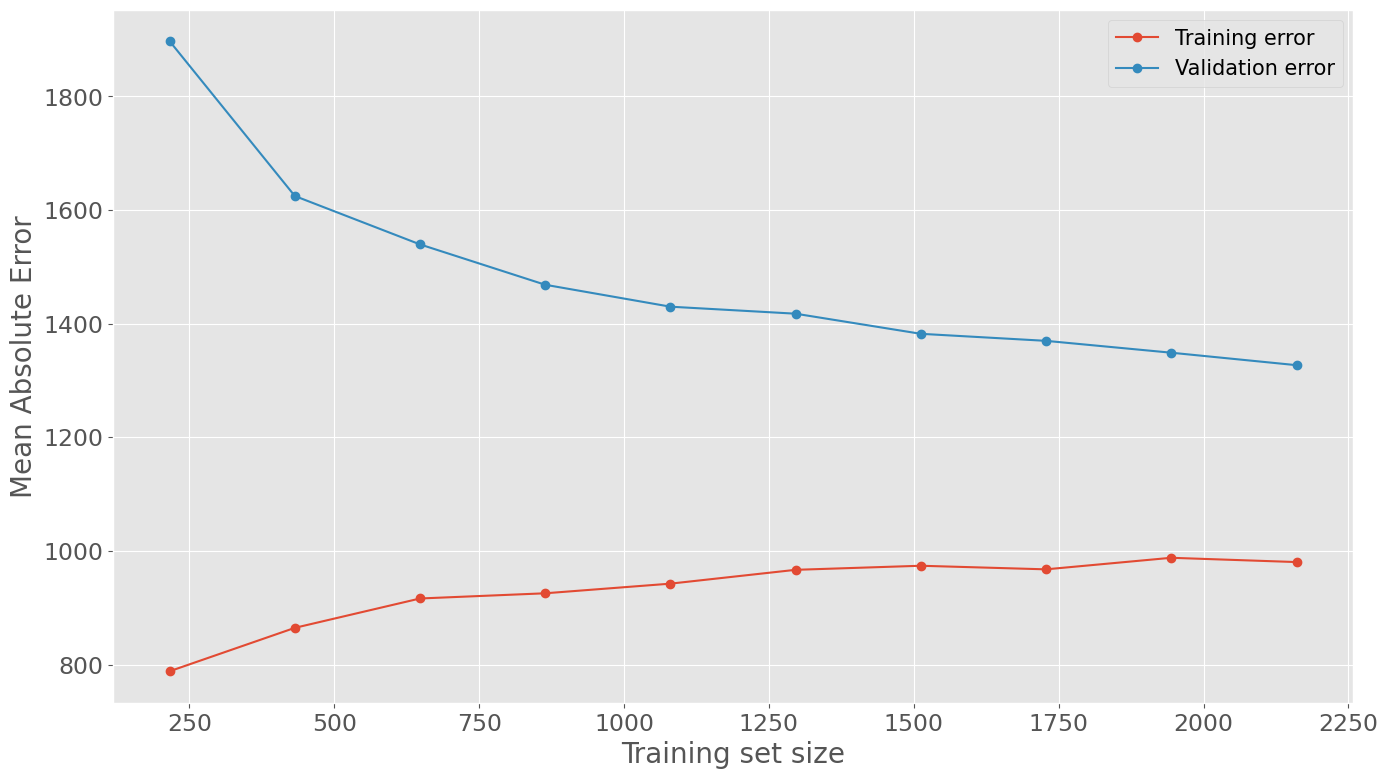

In [106]:
########### Plot Learning Curve ###########

plt.figure(figsize=(16, 9))
plt.plot(train_sizes, train_scores_mean, 'o-',  label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation error')
plt.xlabel('Training set size', fontsize = 20)
plt.ylabel('Mean Absolute Error', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.rc('xtick', labelsize='17')
plt.rc('ytick', labelsize='17')
plt.rc('axes', titlesize='15')
plt.show()

/var/folders/zd/qsfm1f5d39ddz1bnq9k3xjwr0000gn/T/ipykernel_40701/2686369707.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


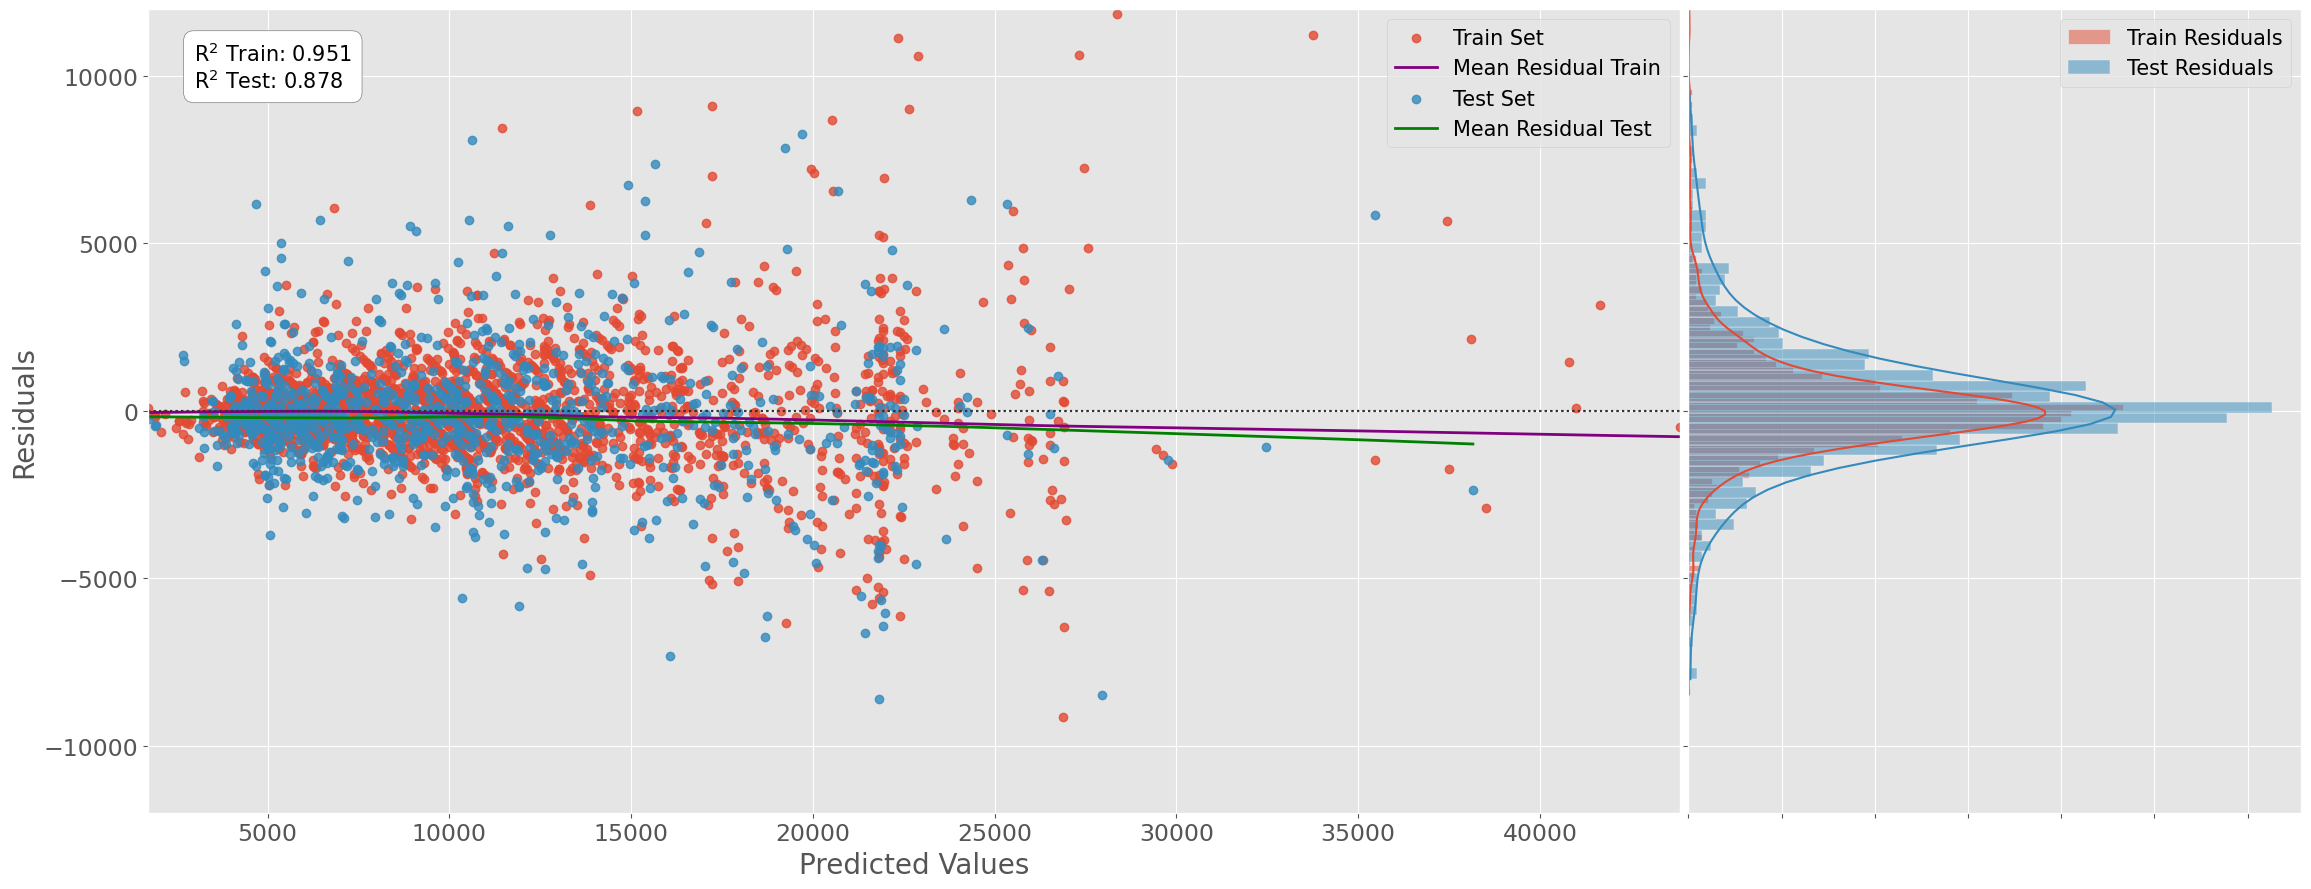

r2 train: 0.9513214540314106
r2 test: 0.8776708374910169


In [107]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

########### Calculate Residuals ###########

residuals_test = y_test - y_pred_ens_test_inv
residuals_train = y_train - y_pred_ens_train_inv

r2train = r2_score(y_train_log, y_pred_ens_train)
r2test = r2_score(y_test_log, y_pred_ens_test)

########### Plot Residuals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_train_inv, y=residuals_train, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = residuals_train, kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y = residuals_test, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2train),
    r'R$^2$ Test: {:.3f}'.format(r2test),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2train)
print("r2 test:", r2test)

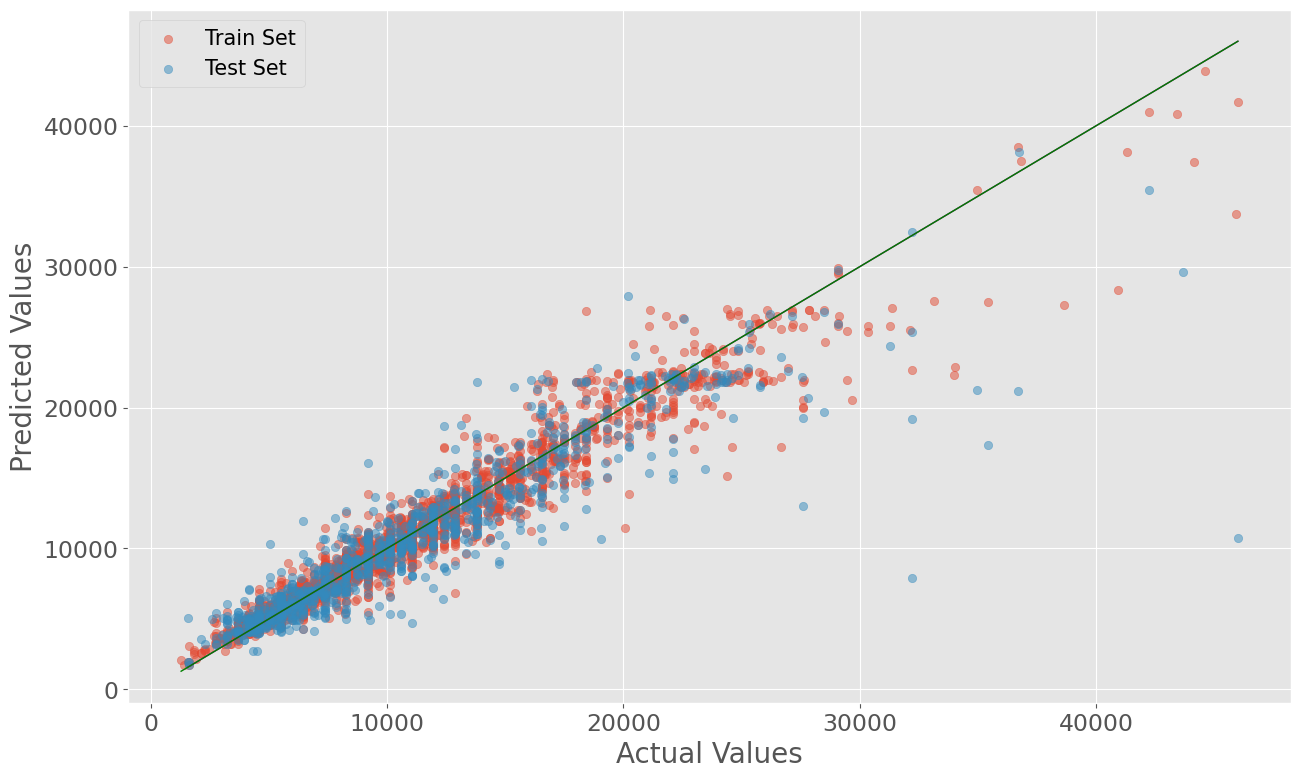

In [108]:
########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_ens_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc='best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()

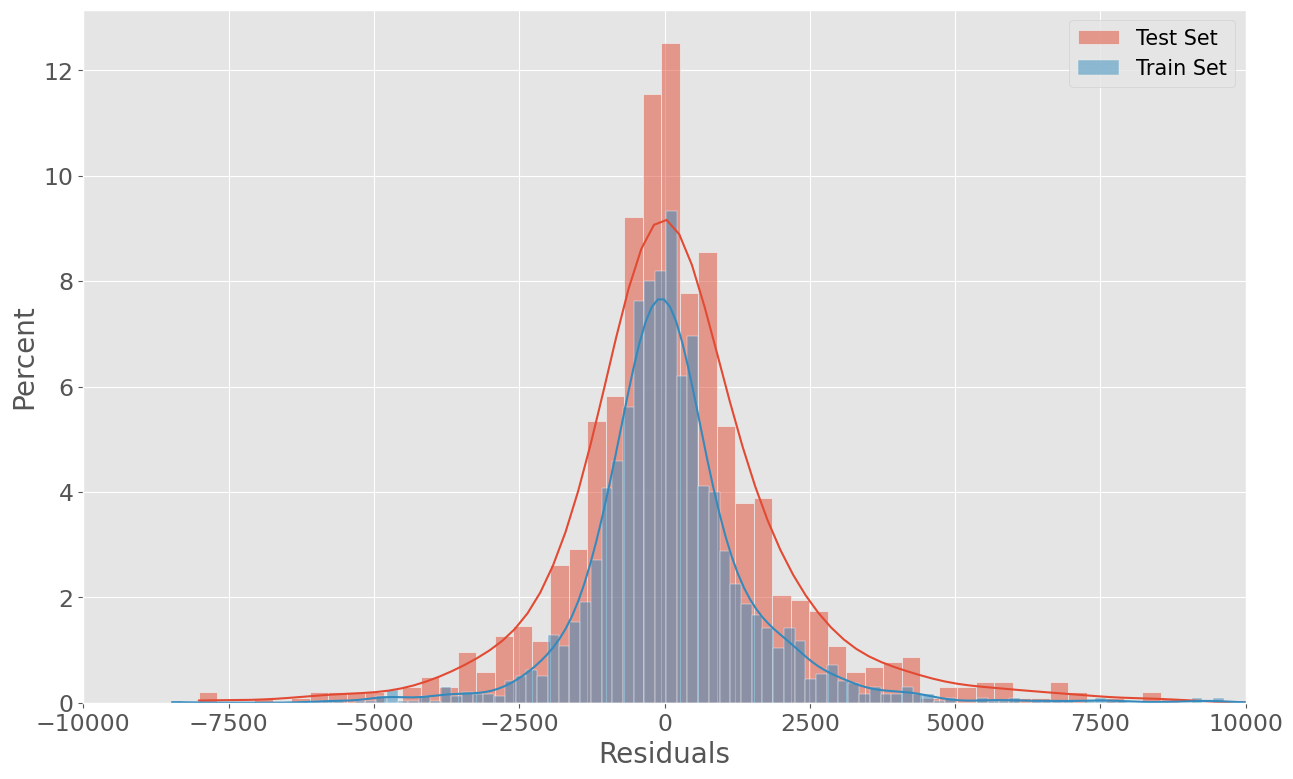

In [109]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, alpha = 0.5, kde=True, stat='percent', label = 'Test Set')
sns.histplot(residuals_train, alpha = 0.5, kde=True, stat='percent', label = 'Train Set')
plt.legend(loc='best', fontsize = 15)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.show()

## **Alternative Method: KNN Regressor**

In [128]:
########### parameter grid ###########

param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 13],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'regressor__leaf_size': [20, 30, 40, 50],
    'regressor__p': [1, 2]
}

########### Initialise base model ###########

knn_model = KNeighborsRegressor(algorithm = 'brute')

########### Pipeline for base model ###########

model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('regressor', knn_model)
])

########### Random Search for best parameters ###########

random_search_knn = RandomizedSearchCV(estimator=model_knn, param_distributions=param_grid_knn, n_iter=200, cv=kf, n_jobs=-1, verbose=2, random_state=42, scoring='neg_mean_squared_error')

########### Fit for Search ###########

random_search_knn.fit(X_train, y_train_log)

########### Set Parameters ###########

best_params_knn = random_search_knn.best_params_
best_knn = model_knn.set_params(**best_params_knn)

start = time.time()
best_knn.fit(X_train, y_train_log) ########### Fit model
stop = time.time()

########### Predict Prices ###########

y_pred_knn = best_knn.predict(X_test)

y_pred_knn_inv = target_transformer_log.inverse_transform(y_pred_knn.reshape(-1, 1)).reshape(-1)

########### Cross Validation with RMSE ###########

cv_scores_knn_rmsle = cross_val_score(best_knn, X_train, y_train_log, cv=kf, scoring=rmsle_scorer)

########### Print Results ###########

print("Metrics for KNN: ")
print(f"Best parameters: {best_params_knn}")
print(f"Cross-Validation RMSE Scores: {-cv_scores_knn_rmsle}")
print(f"Mean RMSE: {-cv_scores_knn_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_knn_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_knn_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_knn))
print('Training Time:', stop-start)

joblib.dump(best_knn, "knn_model.pkl")
# shutil.copyfileobj(open("knn_model.pkl", "rb"), gzip.open("knn_model.pkl.gz", "wb"))
# os.remove("knn_model.pkl")



Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regresso

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neigh

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neigh

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regres

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.3s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.3s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.3s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.3s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_n

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3,

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=9, regress

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbor

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor_

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbor

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighb

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbo

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11,

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighb

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbor

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3,

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=1

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighb

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use


[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, reg

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regr

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, reg

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=3, reg

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regres

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_ne

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neigh

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.2s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regr

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighb

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neigh

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neigh

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=7, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=1

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=5, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_ne

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=50, regressor__n_neighbo

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, re

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regress

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=13, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=13, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=40, regressor__n_neig

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=5, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=40, regresso

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=30, regressor__n_neighbo

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=9, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neig

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=50, regressor__n_neighbors=3, regressor__p=2, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=50, regressor__n_neighbors=5, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=brute, regressor__leaf_size=30, regressor__n_neighbors=3, regressor__p=1, regressor__weights=uniform; total time=   0.1s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighb

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.2s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.2s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=9, regressor__p=2, regressor__weights=uniform; total time=   0.2s


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=auto, regressor__leaf_size=20, regressor__n_neighbors=7, regressor__p=2, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=30, regressor__n_neighbors=7, regressor__p=1, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=auto, regressor__leaf_size=30, regressor__n_neighbors=

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.2s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.4s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.3s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.1s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=40, regressor__n_neighbors=11, regressor__p=2, regressor__weights=uniform; total time=   0.4s
[CV] END regressor__algorithm=kd_tree, regressor__leaf_size=20, regres

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use

[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=50, regressor__n_neighbors=11, regressor__p=1, regressor__weights=distance; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=20, regressor__n_neighbors=11, regressor__p=1, regressor__weights=uniform; total time=   0.0s
[CV] END regressor__algorithm=ball_tree, regressor__leaf_size=2

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/neighbors/_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Metrics for KNN: 
Best parameters: {'regressor__weights': 'distance', 'regressor__p': 1, 'regressor__n_neighbors': 7, 'regressor__leaf_size': 30, 'regressor__algorithm': 'auto'}
Cross-Validation RMSE Scores: [1740.4976226  2235.93890672 2928.29113907 2486.71477826 2218.32420796
 2290.86073654 2120.44358232 2322.92964712 2682.19139453 2157.55153448]
Mean RMSE: 2318.3743549601777
Standard Deviation of RMSE: 308.10149188356536
MSE: 7294870.32
MAE: 1524.50
R2-Score: 0.854
Training Time: 0.007357358932495117


['knn_model.pkl']

Metrics for KNN: 

Best parameters: {'regressor__weights': 'distance', 'regressor__p': 1, 'regressor__n_neighbors': 9, 'regressor__leaf_size': 30, 'regressor__algorithm': 'brute'}

Cross-Validation RMSE Scores: [2377.92342683 3591.76083688 2403.09033469 2326.03507088 2490.74604856 2172.2016863  2545.23792788 2467.29637138 2809.09758649 1971.88264244]

Mean RMSE: 2515.5271932342266

Standard Deviation of RMSE: 415.83547059024744

MSE: 5167510.12

MAE: **1418.12**

R2-Score: **0.877**

Training Time: 0.015s

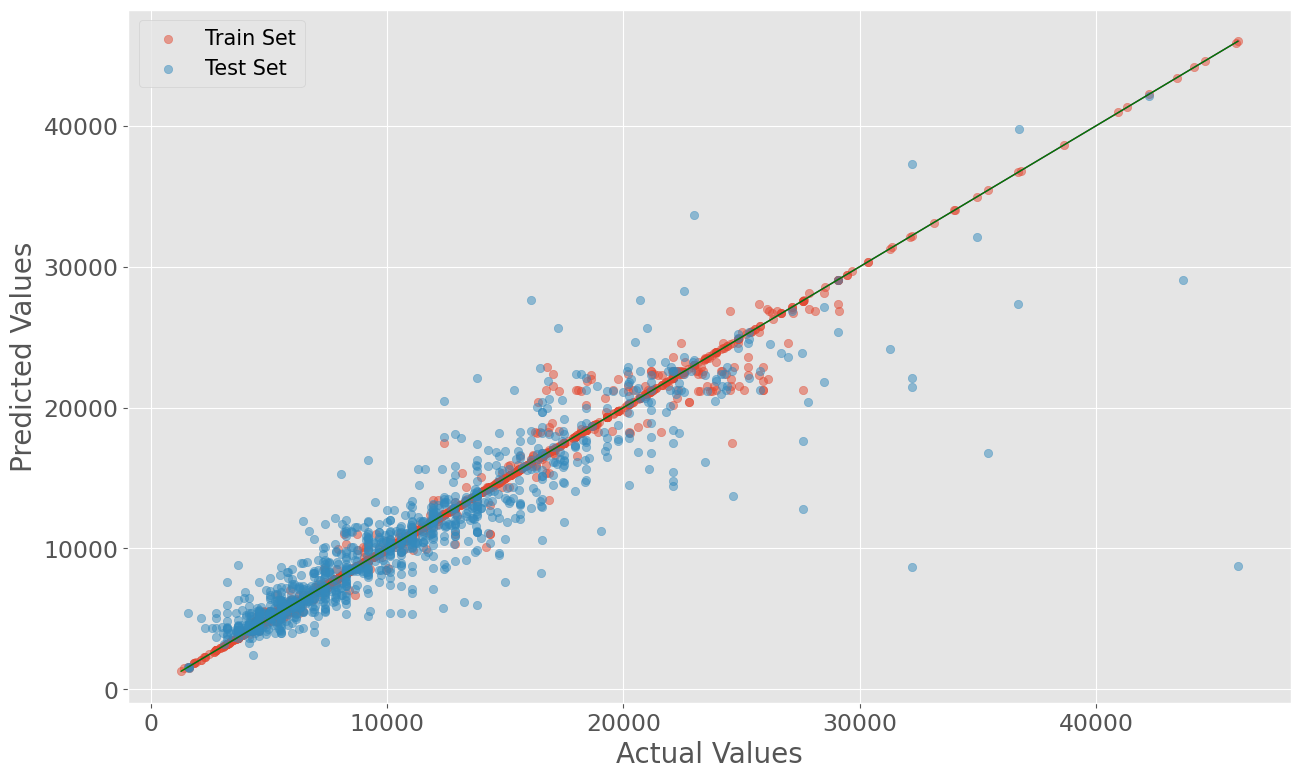

MAE: 1524.50
R2-Score Test: 0.85
R2-Score Train: 1.00


In [111]:
########### Predict Prices for testing and training ###########

y_pred_knn_test = best_knn.predict(X_test)
y_pred_knn_test_inv = target_transformer_log.inverse_transform(y_pred_knn_test.reshape(-1, 1)).reshape(-1)
y_pred_knn_train = best_knn.predict(X_train)
y_pred_knn_train_inv = target_transformer_log.inverse_transform(y_pred_knn_train.reshape(-1, 1)).reshape(-1)

########### Plot Errors ###########

plt.figure(figsize=(15, 9))
plt.scatter(y_train, y_pred_knn_train_inv, alpha=0.5, label='Train Set')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'purple', linewidth=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color = 'green',  linewidth=1)
plt.legend(loc = 'best', fontsize = 15)
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.show()
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_knn_test_inv))
print('R2-Score Test: %.2f' % r2_score(y_test_log, y_pred_knn_test))
print('R2-Score Train: %.2f' % r2_score(y_train_log, y_pred_knn_train))

MAE: 1418.09
R2-Score Test: 0.88
R2-Score Train: 0.99

/var/folders/zd/qsfm1f5d39ddz1bnq9k3xjwr0000gn/T/ipykernel_40701/2240181750.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


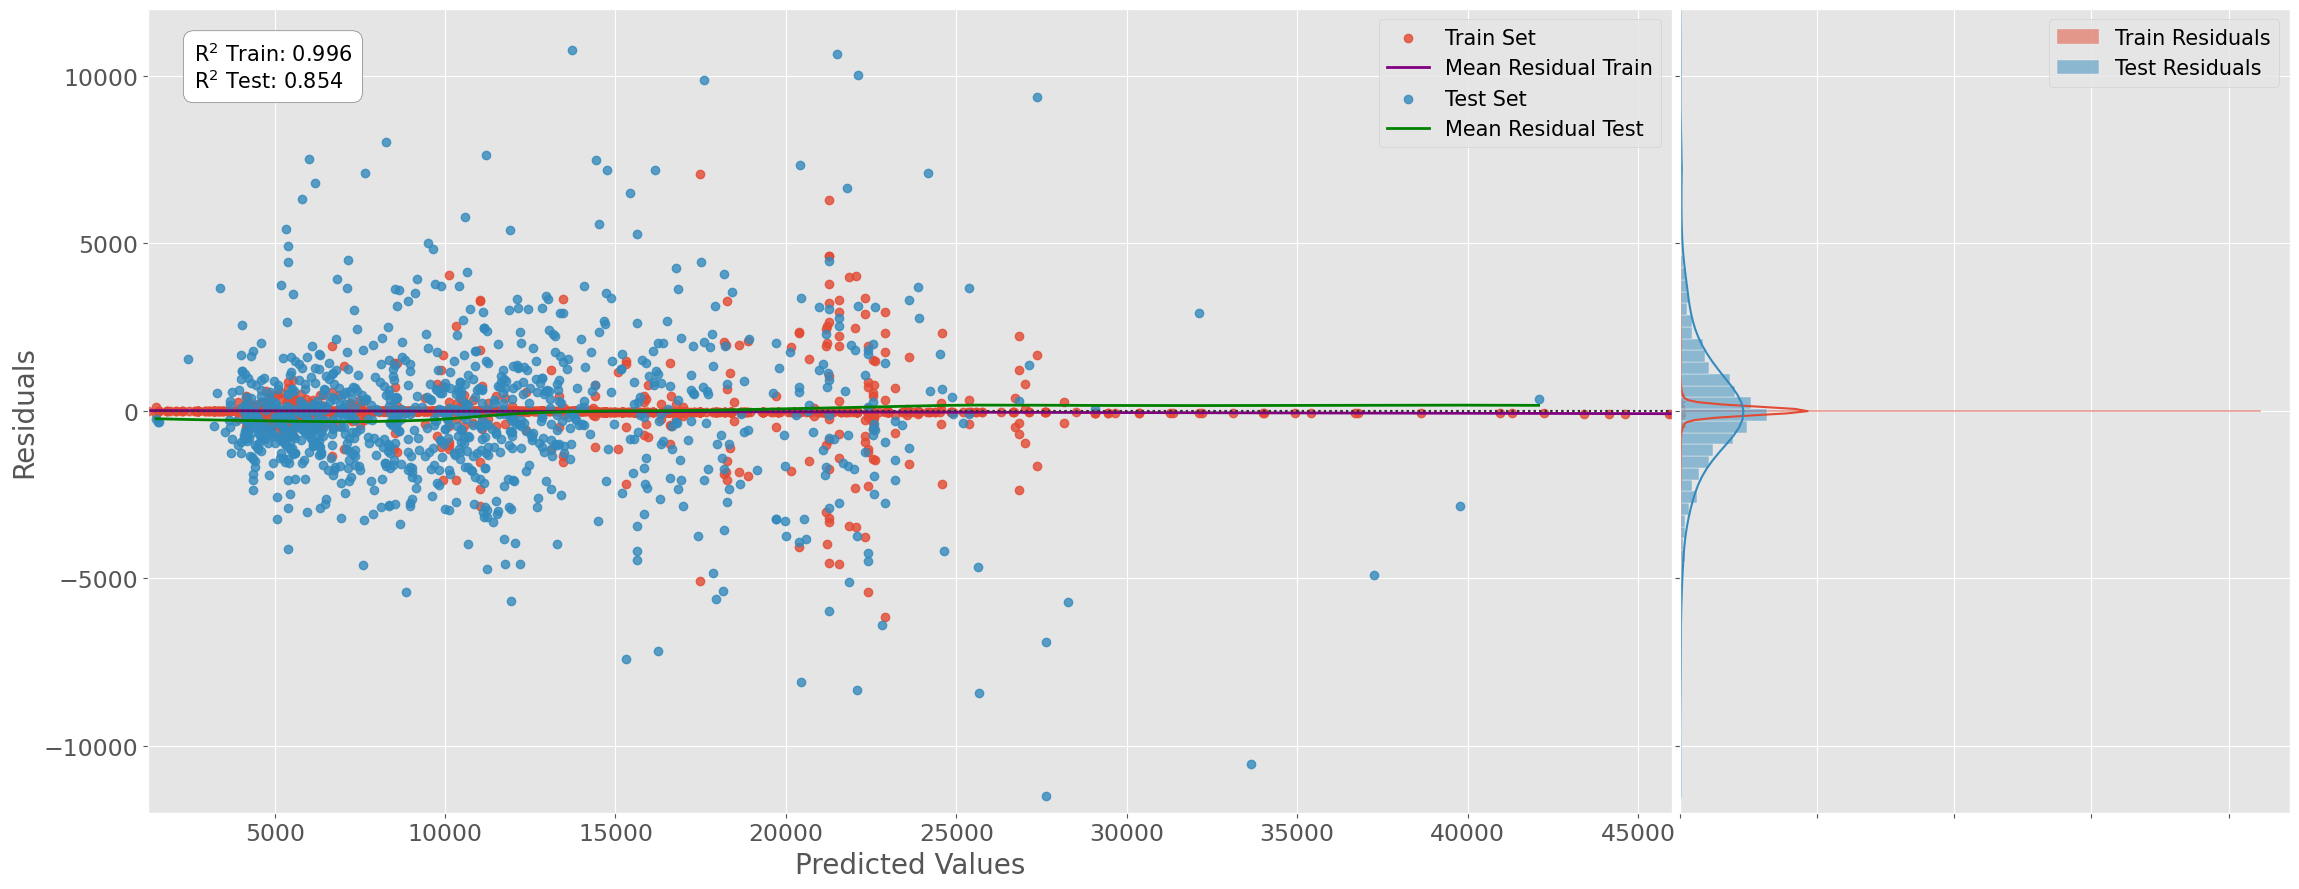

r2 train: 0.9955213133527836
r2 test: 0.8542366298375754


In [112]:
########### r2 scores ###########

r2trainknn = r2_score(y_train_log, y_pred_knn_train)
r2testknn = r2_score(y_test_log, y_pred_knn_test)

########### Residuals ###########

residuals_test_knn = y_test - y_pred_knn_test_inv
residuals_train_knn = y_train - y_pred_knn_train_inv

########### Residuals Plot ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_knn_train_inv, y=residuals_train_knn, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Train'}, label='Train Set')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual Test'}, label='Test Set')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values', fontsize = 20)
plt.ylabel('Residuals', fontsize = 20)

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = y_train - np.round(y_pred_knn_train_inv,10), kde=True,stat = 'percent',  label='Train Residuals', alpha=0.5, ax = ax_hist, bins = 200)
sns.histplot(y = residuals_test_knn, kde=True, stat = 'percent', label='Test Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")
ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Train: {:.3f}'.format(r2trainknn),
    r'R$^2$ Test: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

print("r2 train:", r2trainknn)
print("r2 test:", r2testknn)

/var/folders/zd/qsfm1f5d39ddz1bnq9k3xjwr0000gn/T/ipykernel_40701/2375406895.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


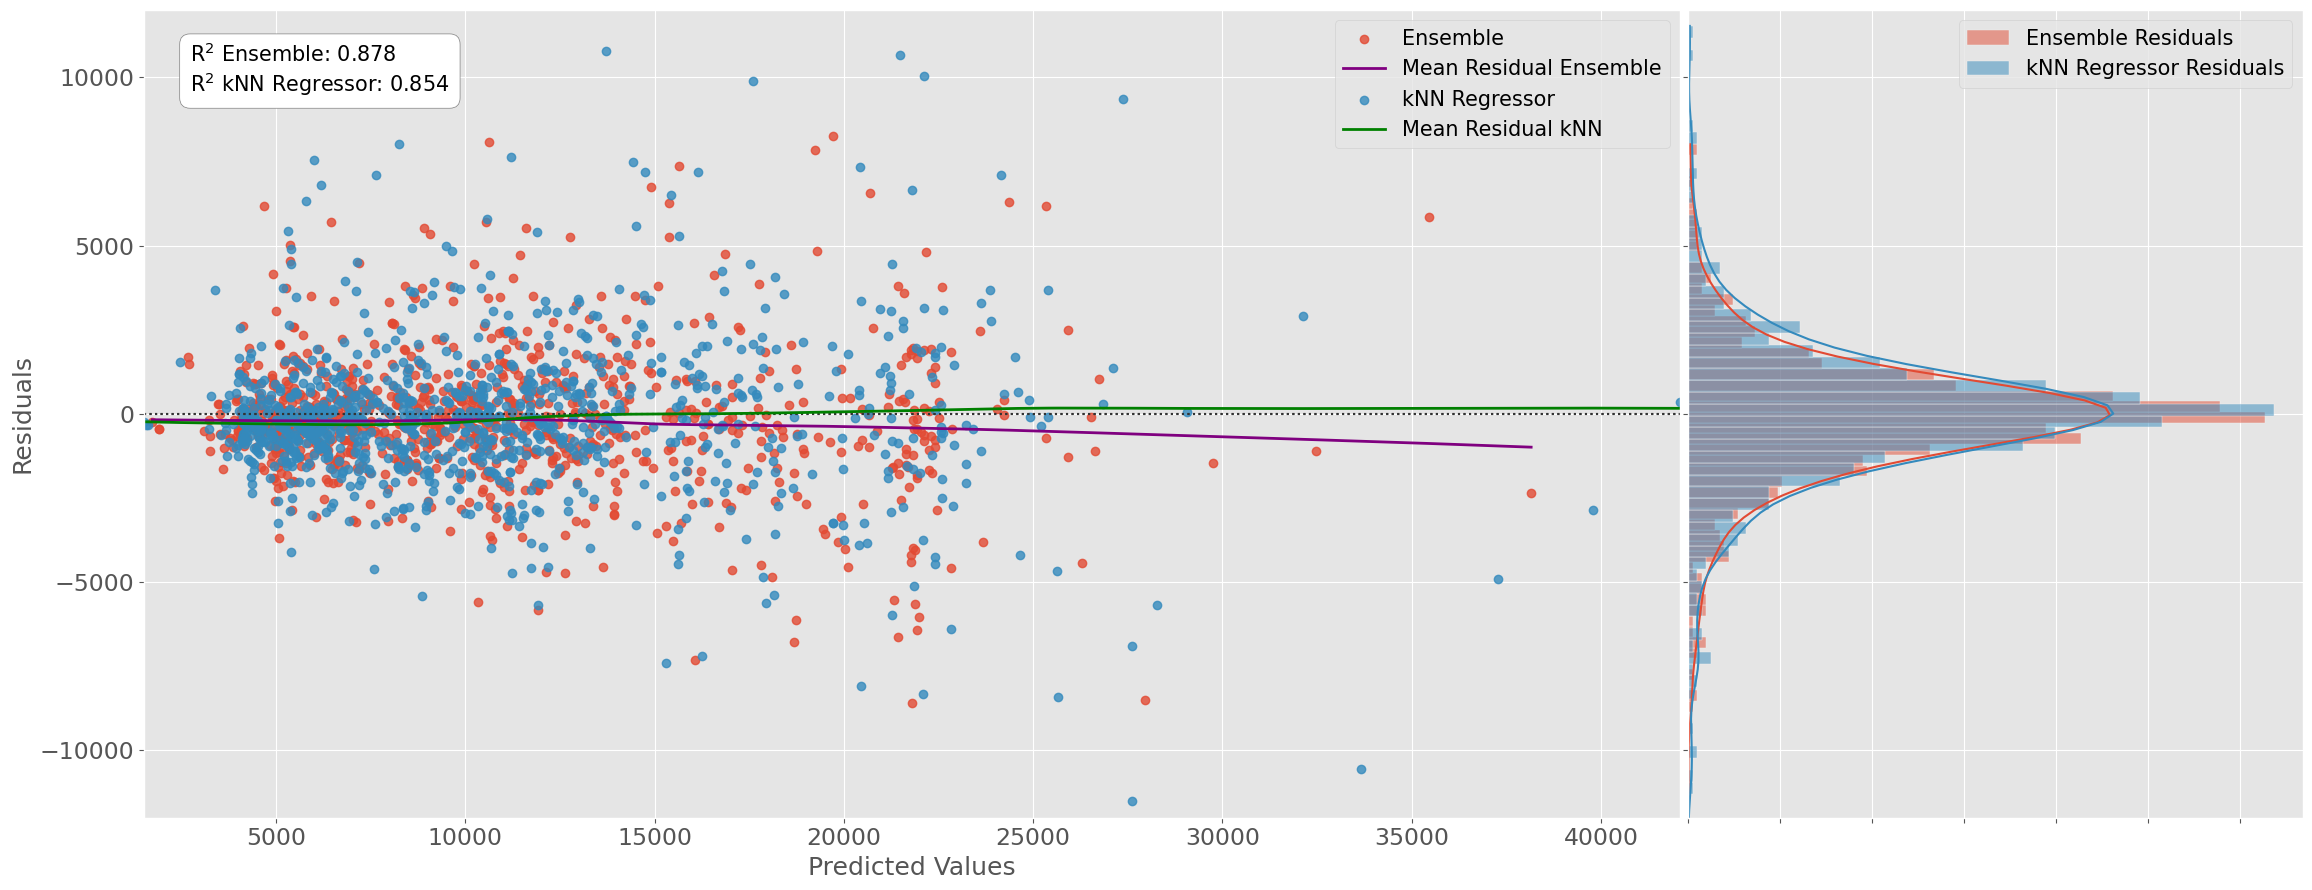

In [113]:
########### Plot Resiudals ###########

plt.figure(figsize=(17, 9))
plt.ylim(-12000, 12000)

sns.residplot(x= y_pred_ens_test_inv, y=residuals_test, lowess=True, line_kws={'color': 'purple', 'lw': 2, 'label':'Mean Residual Ensemble'}, label='Ensemble')
sns.residplot(x= y_pred_knn_test_inv, y=residuals_test_knn, lowess=True, line_kws={'color': 'green', 'lw': 2, 'label':'Mean Residual kNN'}, label='kNN Regressor')

plt.legend(loc='best', fontsize = 15)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

ax_residuals = plt.gca()

ax_hist = inset_axes(ax_residuals, width="100%", height="100%", loc='center right',
                     bbox_to_anchor=(1.01, 0, 0.4, 1), bbox_transform=ax_residuals.transAxes)

sns.histplot(y = -residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5, ax = ax_hist)
sns.histplot(y =-residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5, ax = ax_hist)

ax_hist.set_yticklabels([])
ax_hist.set_xticklabels([])
ax_hist.set_ylabel("")
ax_hist.set_xlabel("")

ax_hist.set_ylim(-12000, 12000)
ax_hist.legend(loc='best', fontsize = 15)

textstr = '\n'.join((
    r'R$^2$ Ensemble: {:.3f}'.format(r2test),
    r'R$^2$ kNN Regressor: {:.3f}'.format(r2testknn),
))
props = dict(boxstyle='round,pad=0.5', edgecolor='grey', facecolor='white')
ax_residuals.text(0.03, 0.96, textstr, transform=ax_residuals.transAxes,
                  verticalalignment='top', bbox=props, fontsize = 15)

plt.tight_layout()

plt.show()

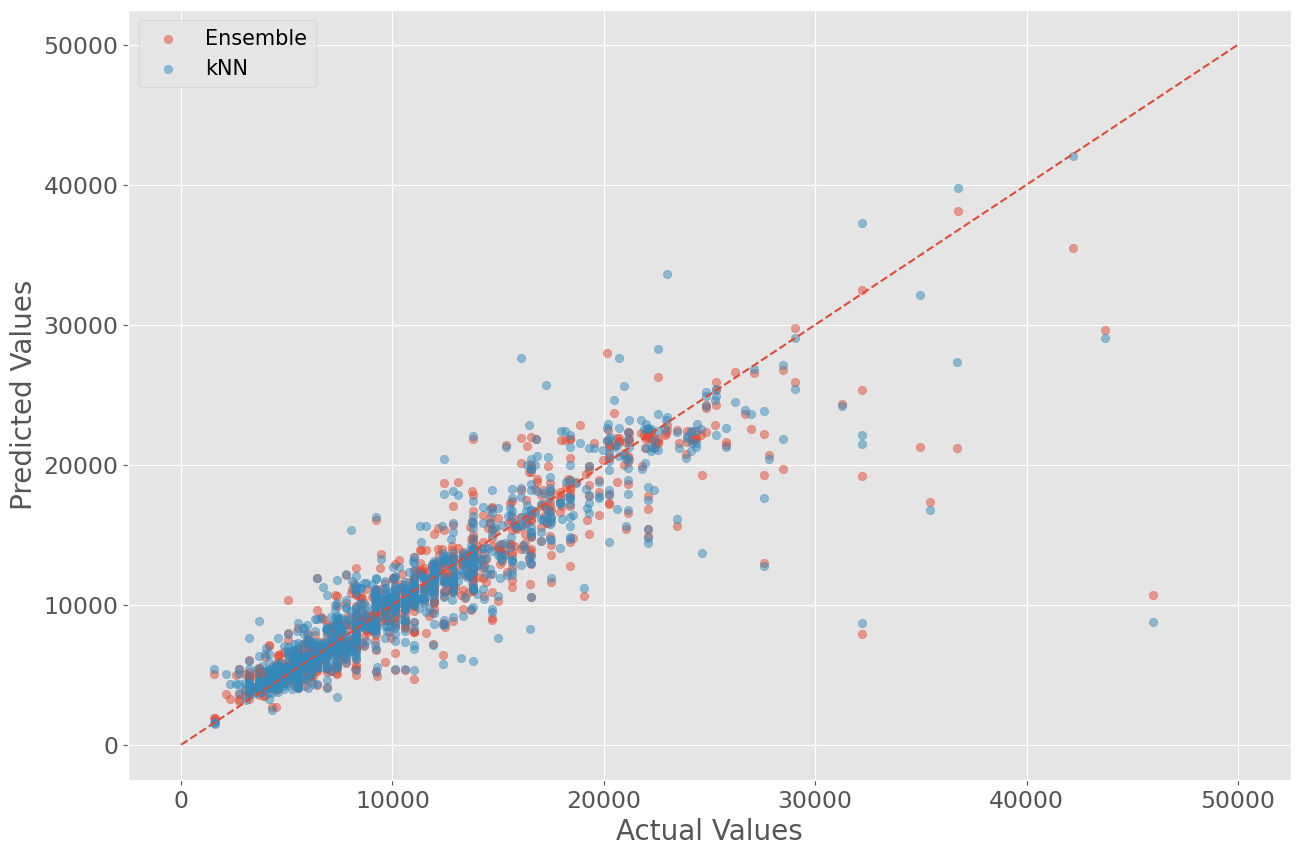

In [114]:
########### Predicted vs actual ###########

plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred_ens_test_inv, alpha=0.5, label='Ensemble')
plt.scatter(y_test, y_pred_knn_test_inv, alpha=0.5, label='kNN')
plt.plot([0, 50000], [0, 50000], '--')
plt.xlabel('Actual Values', fontsize = 20)
plt.ylabel('Predicted Values', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

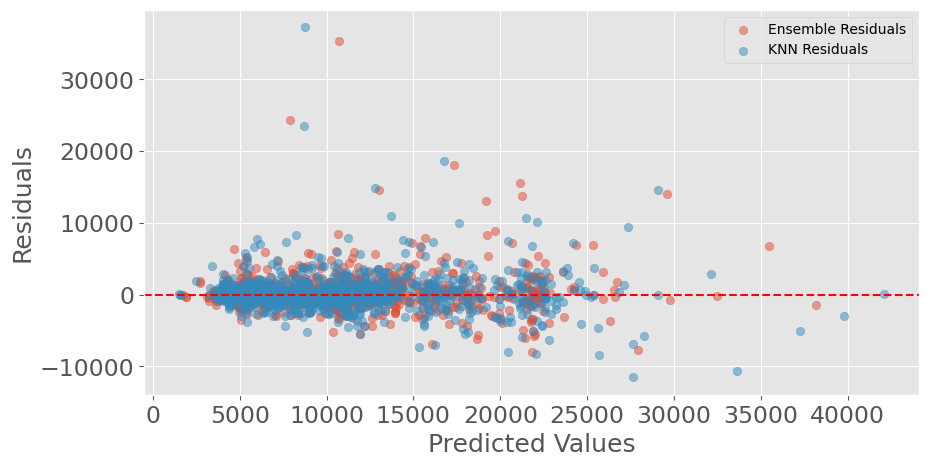

In [115]:
########### Plot Residuals ###########

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_ens_test_inv, residuals_test, alpha=0.5, label='Ensemble Residuals')
plt.scatter(y_pred_knn_test_inv, residuals_test_knn, alpha=0.5, label='KNN Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

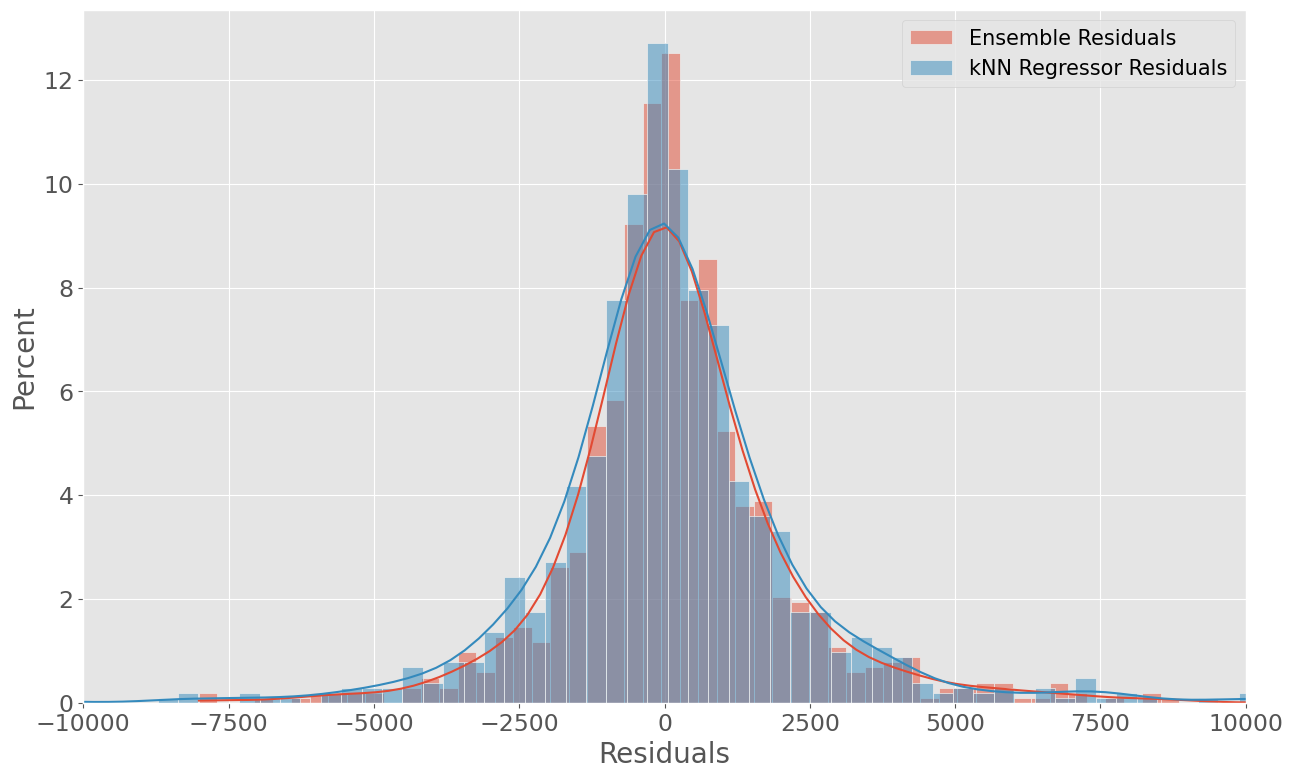

In [116]:
########### Plot Residuals ###########

plt.figure(figsize=(15, 9))
sns.histplot(residuals_test, kde=True,stat = 'percent',  label='Ensemble Residuals', alpha=0.5)
sns.histplot(residuals_test_knn, kde=True, stat = 'percent', label='kNN Regressor Residuals', alpha=0.5)
plt.xlim(-10000, 10000)
plt.xlabel('Residuals', fontsize = 20)
plt.ylabel('Percent', fontsize = 20)

plt.legend(loc='best', fontsize = 15)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


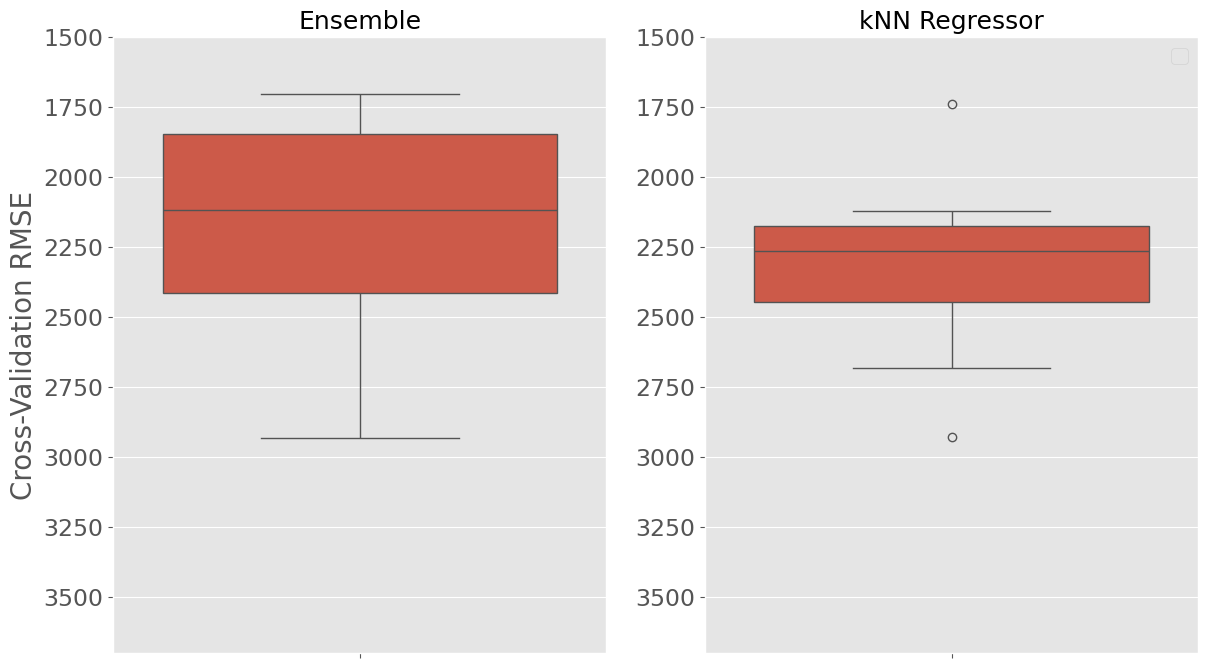

In [117]:
########### Plot Box Plot for Cross Vals ###########

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.boxplot(y=np.abs(cv_scores_ensemble_rmse),ax = axes[0])
sns.boxplot(y=np.abs(cv_scores_knn_rmsle),ax = axes[1])
axes[0].set_title('Ensemble', fontsize = 18)
axes[1].set_title('kNN Regressor', fontsize = 18)

axes[0].set_ylim(3700, 1500)
axes[1].set_ylim(3700, 1500)
axes[0].set_ylabel('Cross-Validation RMSE', fontsize = 20)
plt.legend(loc='best', fontsize = 15)
plt.show()

In [118]:
########### Predict prices for whole dataset and visualise ###########

df_True_pred = X_test
df_True_pred['True Prices [€]'] = y_test
df_True_pred['Predicted Prices [€]'] = y_pred_ens_test_inv
df_True_pred['Difference [€]'] = np.abs(residuals_test)
df_True_pred.rename = residuals_test
df_True_pred = df_True_pred[['Brand', 'Bike', 'Category', 'Power [hp]', 'Displacement [ccm]', 'Torque [Nm]', 'Mileage [km]', 'Age [a]', 'True Prices [€]', 'Predicted Prices [€]', 'Difference [€]']]
df_True_pred.sort_values(by = 'Difference [€]', ascending=False).head(10).style.format({'Power [hp]': "{:,.0f}", 'Displacement [ccm]': "{:,.0f}", 'Torque [Nm]': "{:,.0f}", 'Mileage [km]': "{:,.0f}", 'True Prices [€]': "{:,.2f} €", 'Predicted Prices [€]': "{:,.2f} €", 'Difference [€]': "{:,.2f} €"})

In [119]:
########### For Variable Importance ###########

param_grid_xgbtree = {
    'regressor__n_estimators': [250, 300, 350],
    'regressor__learning_rate': [0.03, 0.05, 0.08],
    'regressor__max_depth': [4, 5, 6],
    'regressor__min_child_weight': [2, 3, 4],
    'regressor__subsample': [0.4, 0.6, 0.7],
    'regressor__colsample_bytree': [0.3, 0.6, 0.8],
    'regressor__gamma': [0, 0.1, 0.3, 0.5],
    'regressor__reg_alpha': [0, 0.01, 0.1, 1],
    'regressor__reg_lambda': [0, 0.01, 0.1, 1]
}


extra_tree_model2 = ExtraTreesRegressor()

model_extratree2 = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('feature_selection', SelectFromModel(ExtraTreesRegressor())),
    ('regressor', extra_tree_model2)
])

model_extratree2.fit(X_train, y_train_log.ravel())

preprocessor_std.fit(X_train)

num_features_out2 = preprocessor_std.transformers_[0][1].named_steps['scaler'].get_feature_names_out(num_features)
cat_features_out2 = preprocessor_std.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features_)
feature_names2 = np.concatenate([num_features_out2, cat_features_out2])
selected_features2 = model_extratree2.named_steps['feature_selection'].get_support()
selected_feature_names2 = feature_names2[selected_features2]

y_pred_xgbtree2 = model_extratree2.predict(X_test)

y_pred_xgbtree2_inv = target_transformer_log.inverse_transform(y_pred_xgbtree2.reshape(-1, 1)).reshape(-1)

cv_scores_xgbtree2_rmsle = cross_val_score(model_extratree2, X_train, y_train_log.ravel(), cv=kf, scoring=rmsle_scorer)

print("Metrics for XGBoost Tree: ")
print(f"Cross-Validation RMSE Scores: {-cv_scores_xgbtree2_rmsle}")
print(f"Mean RMSE: {-cv_scores_xgbtree2_rmsle.mean()}")
print(f"Standard Deviation of RMSE: {cv_scores_xgbtree2_rmsle.std()}")
print('MSE: %.2f' % mean_squared_error(y_test, y_pred_xgbtree2_inv))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred_xgbtree2_inv))
print('R2-Score: %.3f' % r2_score(y_test_log, y_pred_xgbtree2))

Metrics for XGBoost Tree: 
Cross-Validation RMSE Scores: [1955.36887859 2253.34086062 2889.74929107 2605.68284897 2195.12421178
 2155.15903051 2029.88725424 2386.35473367 2859.07607893 2239.30844654]
Mean RMSE: 2356.9051634942543
Standard Deviation of RMSE: 309.5896217299388
MSE: 7702609.02
MAE: 1573.05
R2-Score: 0.851


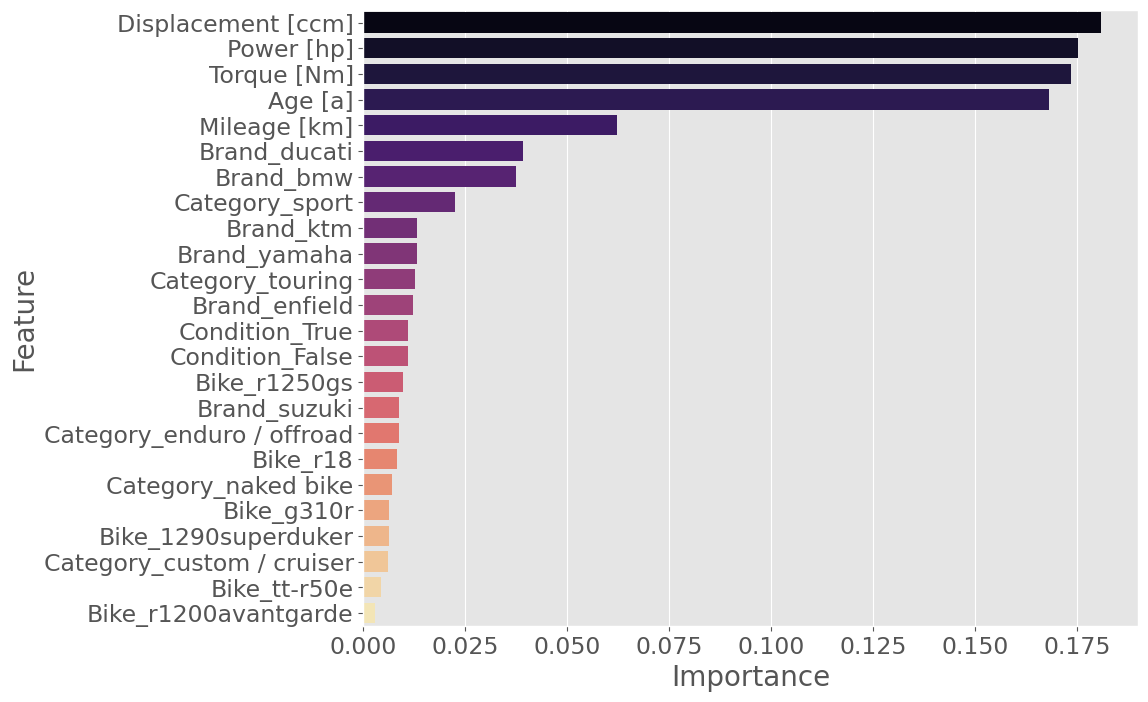

In [120]:
########### Plot Importance ###########

xgb_model3 = model_extratree2.named_steps['regressor']

importances2 = xgb_model3.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names2,
    'importance': importances2
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='magma', hue = 'feature')
plt.xlabel('Importance', fontsize = 20)
plt.ylabel('Feature', fontsize = 20)
plt.show()